# process list
1. 데이터의 특징을 파악하기
    - err_data와 quality_data에는 어떤 컬럼이 있고 그 컬럼이 의미하는 것은 무엇인지 파악
    - 각 컬럼별 특징 파악
2. 데이터의 타입을 알맞게 변경하고 널값 제거 또는 대치
3. 각 컬럼별로 count, sum, mean, max, min, mode등을 파악
4. 그래프를 그려보고 어떤 규칙이 있는지 찾아내야함.
5. 규칙은 곧, 여러행을 하나의 컬럼으로 바꿔주는 역할임(ex. 오전오후)

# Library Import

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
import seaborn as sns
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour, mim)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


PATH = '/kaggle/input/dacon-lg/'

In [2]:
'''
train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_qual = pd.read_csv(PATH+'train_quality_data.csv')
train_prob = pd.read_csv(PATH+'train_problem_data.csv')

test_err = pd.read_csv(PATH+'test_err_data.csv')
test_qual = pd.read_csv(PATH+'test_quality_data.csv')
display(train_err.head())
display(train_qual.head())
'''

"\ntrain_err  = pd.read_csv(PATH+'train_err_data.csv')\ntrain_qual = pd.read_csv(PATH+'train_quality_data.csv')\ntrain_prob = pd.read_csv(PATH+'train_problem_data.csv')\n\ntest_err = pd.read_csv(PATH+'test_err_data.csv')\ntest_qual = pd.read_csv(PATH+'test_quality_data.csv')\ndisplay(train_err.head())\ndisplay(train_qual.head())\n"

In [3]:
'''
# 중복값 제거
print('중복값 제거 전 train_err 개체수:',len(train_err))
print('중복값 제거 전 train_qual 개체수:',len(train_qual))

train_err = train_err.drop_duplicates()
train_qual = train_qual.drop_duplicates()
print('중복값 제거 후 train_err 개체수:',len(train_err))
print('중복값 제거 후 train_qual 개체수:',len(train_qual))
'''

# 중복값을 함부로 제거하면 안된다!! 카운트할때 정보가 누락됨!

"\n# 중복값 제거\nprint('중복값 제거 전 train_err 개체수:',len(train_err))\nprint('중복값 제거 전 train_qual 개체수:',len(train_qual))\n\ntrain_err = train_err.drop_duplicates()\ntrain_qual = train_qual.drop_duplicates()\nprint('중복값 제거 후 train_err 개체수:',len(train_err))\nprint('중복값 제거 후 train_qual 개체수:',len(train_qual))\n"

# train_err_data

In [4]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')

### variable describtion
1. user_id: 유저 아이디
2. time: 에러 발생 시각
3. model_nm: 모델명
4. fwver: 펌웨어 버전
5. errtype: 에러타입
6. errcode: 에러코드

In [5]:
# null값 확인
display(train_err.isnull().sum())

# 데이터타입 확인
train_err.info()

# 기술통계 확인
display(train_err.describe())

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 757.8+ MB


,user_id,time,errtype
count,1.655466e+07,1.655466e+07,1.655466e+07
mean,1.758495e+04,2.020112e+13,2.128030e+01
std,4.341885e+03,8.664375e+06,9.943175e+00
min,1.000000e+04,2.020103e+13,1.000000e+00
25%,1.392500e+04,2.020111e+13,1.500000e+01
50%,1.748500e+04,2.020112e+13,2.300000e+01
75%,2.122700e+04,2.020112e+13,3.100000e+01
max,2.499900e+04,2.020120e+13,4.200000e+01


- 결측치를 확인한 결과 train_err에는 errcode에 1개가 발견되었다. errcode의 경향에 따라 최빈값으로 대치하거나 삭제할 수 있다.
- 각 컬럼별로 데이터타입을 확인한 결과,
    - user_id는 명목형변수이지만 int로 표시된다
    - time은 시간데이터이지만 int로 표시된다
    - model_nm은 모델명으로서 명목형변수이고 object(str)으로 표시된다. int로 바꿀 필요가 있다.
    - fwver도 위와 마찬가지로 명목형 int값으로 바꿀필요가 있다.
    - errtype은 명목형 int이고 바꿀필요는 없다.
    - errcode는 명목형 object(str)이기때문에 int로 바꿀 필요가 있다? 변수에 대한 탐구가 더 필요하다.

In [6]:
print("size of train_err:", train_err.shape)

size of train_err: (16554663, 6)


In [7]:
print("number of unique values\n", train_err.nunique())

number of unique values
 user_id       15000
time        2566163
model_nm          9
fwver            37
errtype          41
errcode        2805
dtype: int64


각 column의 unique values
1. user_id: 15000개 -> 몇부터 몇까지 인가?
2. time: 25666163개 인데 사실 유니크값은 큰 의미가 없다. 범위가 어떻게 되는지 파악해야함
3. model_nm: 9개 -> 한 유저아이디당 한개의 모델을 갖는가?
4. fwver: 37개 -> 한 유저아이디당 한개의 펌웨어버전을 갖는가?
5. errtype: 41개 -> 몇부터 몇까지?
6. errcode: 2805개 -> 속성값은 어떻게 생겼는가?


In [8]:
display(train_err.head())
display(train_err.tail())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


,user_id,time,model_nm,fwver,errtype,errcode
16554658,24999,20201130163051,model_3,05.15.2138,15,1
16554659,24999,20201130172625,model_3,05.15.2138,16,1
16554660,24999,20201130172625,model_3,05.15.2138,4,0
16554661,24999,20201130172631,model_3,05.15.2138,4,0
16554662,24999,20201130210625,model_3,05.15.2138,15,1


### 1. user_id
- user_id의 최소값과 최대값은 몇인가?
- 한개의 유저아이디당 몇개의 관측치를 갖고있는가?

In [9]:
# user_id의 최소값과 최대값
train_id_min = train_err.user_id.min()
train_id_max = train_err.user_id.max()
print("user_id 최소값:", train_id_min)
print("user_id 최대값:", train_id_max)

user_id 최소값: 10000
user_id 최대값: 24999


In [10]:
# 한개의 유저아이디 당 몇개의 관측치를 갖고 있는가?
train_id_cnt = pd.concat([train_err["user_id"], train_err["time"]], axis=1)
train_id_cnt = train_id_cnt.groupby(train_id_cnt["user_id"]).count()

# 컬럼명 변경
train_id_cnt.columns = ['id_count']

display(train_id_cnt.head())
display(train_id_cnt.tail())

print("id당 발생횟수 요약통계")
display(train_id_cnt.describe())
print("id당 발생횟수 중앙값:",train_id_cnt.id_count.median())
print("id당 발생횟수 최빈값:",train_id_cnt.id_count.mode())

,id_count
user_id,
10000,317
10001,2365
10002,306
10003,306
10004,777


,id_count
user_id,
24995,194
24996,4
24997,826
24998,155
24999,570


id당 발생횟수 요약통계


,id_count
count,15000.000000
mean,1103.644200
std,3561.565741
min,1.000000
25%,402.750000
50%,657.000000
75%,1047.000000
max,222186.000000


id당 발생횟수 중앙값: 657.0
id당 발생횟수 최빈값: 0    4
dtype: int64


* id 당 에러는 평균 1103회, 중앙값 657회, 최소 1회는 발생하며, 최대 222186회 발생하기도 한다. 발생 빈도를 시각화 해보자. 중앙값과 평균의 차이는 최대값이 이상치라서 그런거 같으니 시각화해서 확인을 해봐야한다.

<AxesSubplot:>

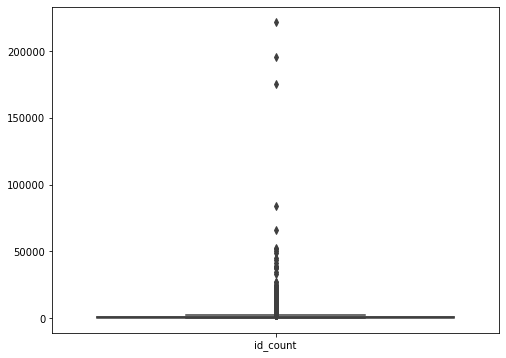

In [11]:
f, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=train_id_cnt)

박스플롯결과 정상적인 형태조차 갖고 있지않았다. 이상치가 너무 압도적이고 다른 값들은 상이한것같다. 따라서 다른 그래프로 확인해보겠다.

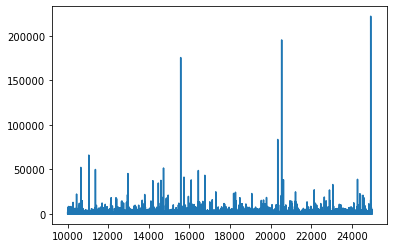

In [12]:
plt.plot(train_id_cnt)

일반 막대그래프로 확인해보니 압도적으로 많은 에러횟수가 3개정도 보이고 5만회 정도의 에러횟수도 굉장히 많아보인다. 추측컨대, 이러한 에러횟수가 많은 id가 불만을 표시했을 확률이 높다.
이를 파생변수로 만들려면 예를들어 에러발생횟수가 50000회 이상인 id는 1로, 그렇지 않은 id는 0으로 만들 수 있을 것이다. 또한 단순히 1과 0이 아니라 횟수의 구간을 나눠서 0,1,2,3 이렇게 나눠도 될 것이다. 하지만 지금은 user_id만을 본 것이기 때문에 다른 변수들도 고려해 봐야한다.

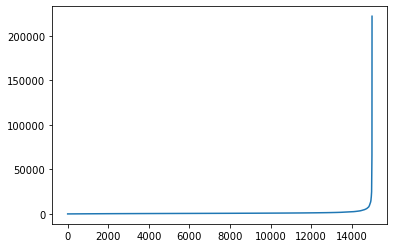

In [13]:
plt.plot(np.sort(train_id_cnt.id_count))

에러발생횟수를 sort하고 시각화 해보니 대부분의 id는 평이하게 나타나다가 소수의 이상치 에러발생횟수들이 압도적으로 높게 나타났따

### 2. model_nm
- user가 가지고 있는 모델명을 나타낸다. 먼저 모델명이 string으로 되어있으니 이를 int값으로 바꿔주는 작업을 해야한다.
- 또한 한 user_id당 한 개의 모델을 가지고 있는지 확인을 해야한다.
- 그렇지 않다면 모델이 바뀐 user가 불만을 표출했을 확률이 높다!
- 이를 파생변수로 만들 수 있을 것이다.

In [14]:
# model_nm의 string값들을 int로 변환
model_dic = dict(enumerate(np.sort(train_err.model_nm.unique())))
# string을 int로 매핑하기위해 키와 밸류를 swap
model_dic = {v:k for k,v in model_dic.items()}

train_err.model_nm = train_err.model_nm.map(model_dic)
train_err.model_nm

0           3
1           3
2           3
3           3
4           3
           ..
16554658    3
16554659    3
16554660    3
16554661    3
16554662    3
Name: model_nm, Length: 16554663, dtype: int64

In [15]:
# 각 모델이 몇회 출현하는지
train_err.model_nm.value_counts()

1    5384491
0    4176279
2    3473254
3    1907438
4    1507802
8      36064
7      35356
5      32233
6       1746
Name: model_nm, dtype: int64

([<matplotlib.axis.XTick at 0x7feebd047bd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

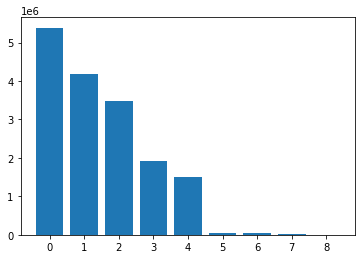

In [16]:
# 모델이 출현한 횟수 시각화
x = np.sort(train_err.model_nm.unique())
y = train_err.model_nm.value_counts()

plt.bar(x, y)
plt.xticks(x)

모델0이 가장 많이 출현한다. 하지만 이 출현횟수는 모델명만 놓고 본 것이기 때문에, 한 유저아이디에 모델명이 엄청나게 많이 출현했을 수도 있다. 즉, 많이 출현했다고 해서 많은 유저아이디에게 출현했다고는 볼 수 없다.

In [17]:
# 한 id에 중복되는 model_nm이 있는가?
data = train_err[['user_id', 'model_nm']].drop_duplicates()
data

,user_id,model_nm
0,10000,3
317,10001,2
2682,10002,3
2988,10003,2
3294,10004,0
...,...,...
16552914,24995,2
16553108,24996,3
16553112,24997,0
16553938,24998,0


확인결과, 704개의 중복값이 있는것을 보아 id 704명은 모델명을 바꿨다고 볼 수 있다. 모델을 바꾼 사실에 대해 파생변수를 추가 할 수 있다. 모델을 바꿨으면 1, 그렇지 않으면 0으로 나타낼 수 있다. 파생변수를 추가하는 작업은 EDA가 끝나고, 더미변수화 시킨후에 하는 것으로 하자.

그럼 이 704명의 id를 대상으로 모델이 바뀐 시점을 기준으로 불만을 표출했는지에 대해 확인할 수 있다.

### 3. time
- 위에서 살펴본 바와 같이 time column은 int로 되어있다. 이를 datetime으로 바꾸어줘야 하고 datetime에서 소요일과 시간 분 까지 나타낼 수 있으면 좋다.
- 먼저 time의 범위를 살펴보자

In [18]:
# time의 범위
train_time_min = train_err.time.min()
train_time_max = train_err.time.max()

print("time의 최소값:", train_time_min)
print("time의 최대값:", train_time_max)

time의 최소값: 20201031235959
time의 최대값: 20201202185152


In [19]:
train_err.time.value_counts()

20201108023257    631
20201108023253    585
20201108022122    526
20201108022121    521
20201108023256    490
                 ... 
20201111230625      1
20201107071158      1
20201113053235      1
20201124011256      1
20201126014318      1
Name: time, Length: 2566163, dtype: int64

<AxesSubplot:>

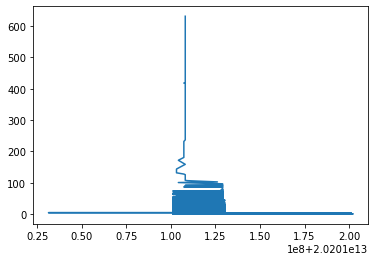

In [20]:
train_err.time.value_counts().plot()

그래프 확인결과 11월 중반부에 많은 에러가 발생했음을 알 수 있다

In [21]:
'''
time_ls = []
for i in tqdm(train_err["time"]):
    time_ls.append(make_datetime(i))

train_err["datetime"] = time_ls
train_err["datetime"]  
'''
# for문은 최대한 쓰지 않으려고 해야한다
# 코드는 최대한 간결하게 써야함!
train_err['datetime'] = train_err['time'].apply(make_datetime)

- 연,월,일은 제외하고 경과일로 바꿔서 새로운 컬럼 생성
- 요일, 시간으로 새로운 컬럼 생성
- 요일과 시간을 바탕으로 시각화 해서 파생변수로 무엇을 선택할지

In [22]:
train_err['weekday'] = train_err['datetime'].dt.weekday
train_err['hour'] = train_err['datetime'].dt.hour

display(train_err)

,user_id,time,model_nm,fwver,errtype,errcode,datetime,weekday,hour
0,10000,20201101025616,3,05.15.2138,15,1,2020-11-01 02:56:00,6,2
1,10000,20201101030309,3,05.15.2138,12,1,2020-11-01 03:03:00,6,3
2,10000,20201101030309,3,05.15.2138,11,1,2020-11-01 03:03:00,6,3
3,10000,20201101050514,3,05.15.2138,16,1,2020-11-01 05:05:00,6,5
4,10000,20201101050515,3,05.15.2138,4,0,2020-11-01 05:05:00,6,5
...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,3,05.15.2138,15,1,2020-11-30 16:30:00,0,16
16554659,24999,20201130172625,3,05.15.2138,16,1,2020-11-30 17:26:00,0,17
16554660,24999,20201130172625,3,05.15.2138,4,0,2020-11-30 17:26:00,0,17
16554661,24999,20201130172631,3,05.15.2138,4,0,2020-11-30 17:26:00,0,17


In [23]:
print(train_err.weekday.value_counts(sort=False))
print(train_err.hour.value_counts(sort=False))

0    2663926
1    2159059
2    2111770
3    2140193
4    2125754
5    2406441
6    2947520
Name: weekday, dtype: int64
0     722370
1     450302
2     691168
3     686960
4     680424
5     554346
6     470877
7     653261
8     718565
9     685861
10    643472
11    629336
12    646229
13    660555
14    635799
15    653461
16    701977
17    767757
18    848590
19    899350
20    848529
21    846325
22    774901
23    684248
Name: hour, dtype: int64


In [24]:
'''
train_min_date = train_err.datetime.min()
train_max_date = train_err.datetime.max()

days_ls = []
for d in tqdm(train_err["datetime"]):
    days_ls.append((d - train_min_date).days)
    
train_err["days"] = days_ls
'''
# 경과일을 구하는 코드
# 마찬가지로 간결한 코드를 지향해야 한다!
min_day = train_err.datetime.min().date()

train_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day
train_err['days'] = train_err['days'].dt.days
display(train_err)

,user_id,time,model_nm,fwver,errtype,errcode,datetime,weekday,hour,days
0,10000,20201101025616,3,05.15.2138,15,1,2020-11-01 02:56:00,6,2,1
1,10000,20201101030309,3,05.15.2138,12,1,2020-11-01 03:03:00,6,3,1
2,10000,20201101030309,3,05.15.2138,11,1,2020-11-01 03:03:00,6,3,1
3,10000,20201101050514,3,05.15.2138,16,1,2020-11-01 05:05:00,6,5,1
4,10000,20201101050515,3,05.15.2138,4,0,2020-11-01 05:05:00,6,5,1
...,...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,3,05.15.2138,15,1,2020-11-30 16:30:00,0,16,30
16554659,24999,20201130172625,3,05.15.2138,16,1,2020-11-30 17:26:00,0,17,30
16554660,24999,20201130172625,3,05.15.2138,4,0,2020-11-30 17:26:00,0,17,30
16554661,24999,20201130172631,3,05.15.2138,4,0,2020-11-30 17:26:00,0,17,30


- 내가 시각화 하고 싶은 그래프는 그래프 행렬이다. 경과일을 달력처럼 칸을 낸 다음 각 칸에 시간별 에러발생횟수의 그래프를 나타내고 싶다.

<AxesSubplot:>

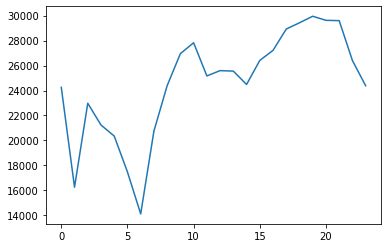

In [25]:
train_err.loc[train_err["days"] == 1].hour.value_counts(sort=False).plot()

In [26]:
train_err.days.value_counts(sort=False)

0          5
1     589297
2     539259
3     528263
4     522174
5     529307
6     558375
7     587836
8     581062
9     539332
10    523930
11    519095
12    526538
13    505044
14    574420
15    591868
16    522448
17    516087
18    539401
19    557735
20    533996
21    649909
22    596759
23    550252
24    590701
25    531097
26    526613
27    528339
28    594271
29    588534
30    512635
31        78
32         3
Name: days, dtype: int64

- 분석의 편의를 위해서 10월 31일 데이터와 12월 1,2일 데이터를 삭제하고 days를 다시 설정해야한다. 11월달의 데이터는 각 날짜별로 50만개가 넘는 값들이 있지만 10월과 12월데이터는 그에비해 매우 적기때문에 삭제할만 하다.



In [27]:
# 월 column을 먼저 만든다
train_err["month"] = train_err["datetime"].dt.month

# 11월이 아닌 값들의 index
month_not11 = train_err[train_err['month'] != 11].index
# 위 인덱스값들을 삭제
train_err1 = train_err.drop(month_not11)

In [28]:
# days column에 전체적으로 -1을 한다.
train_err1["days"] = train_err1["days"] - 1
train_err1.days.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

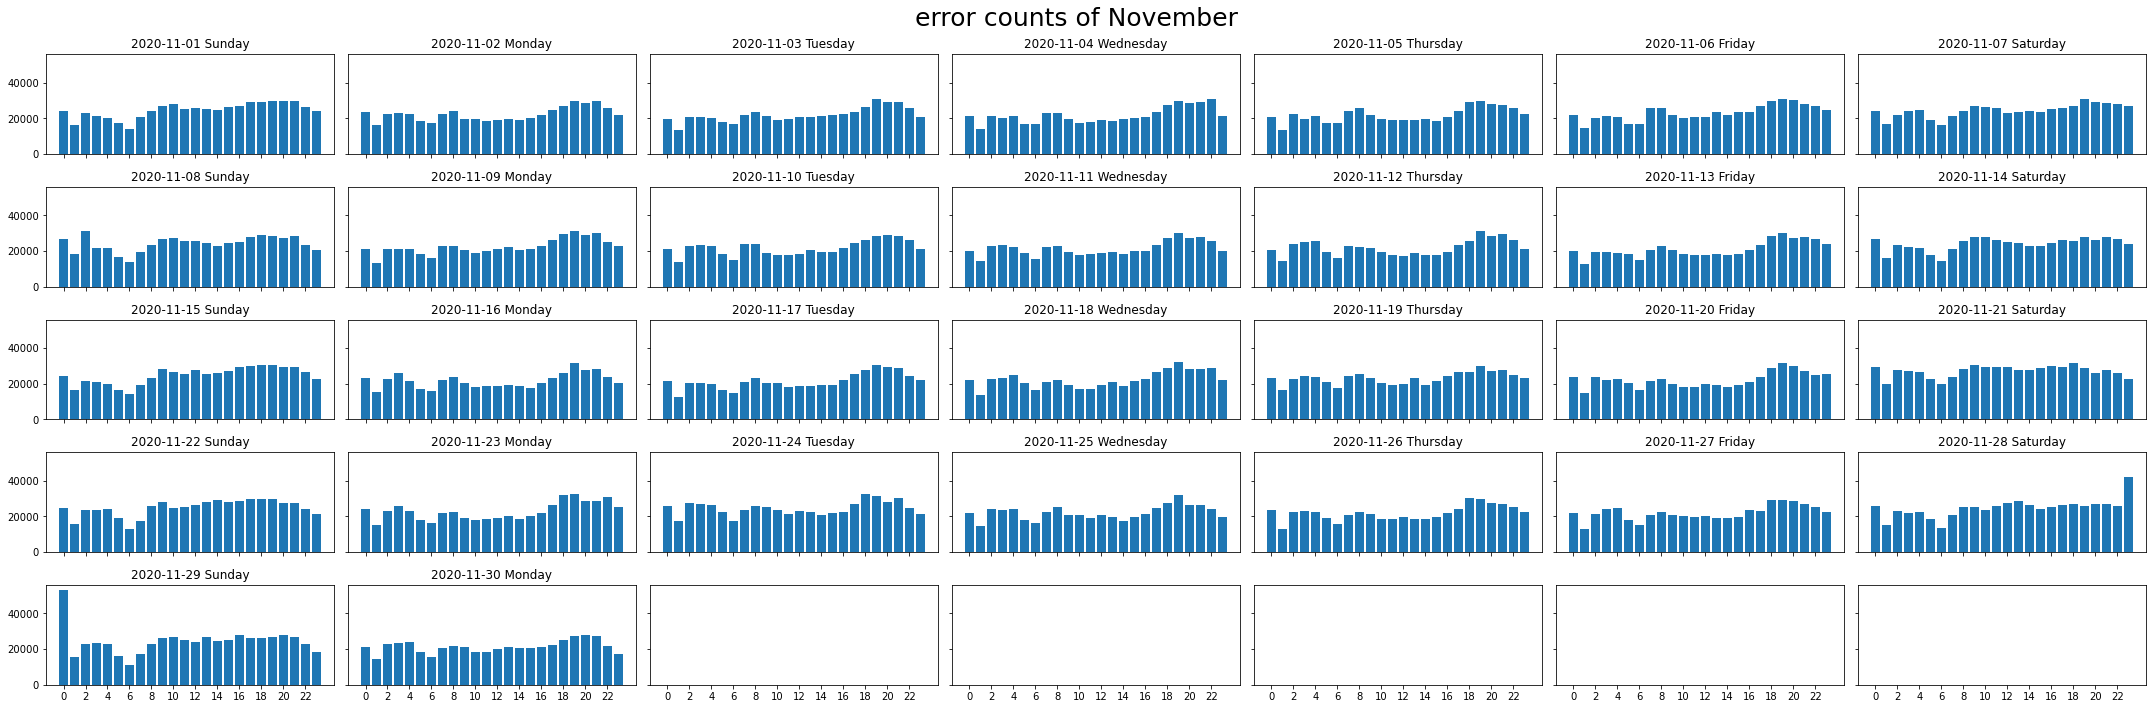

In [29]:
fig , axs = plt.subplots(nrows=5,ncols=7,figsize=(30,10), sharex=True, sharey=True)
plt.suptitle("error counts of November", size=25)

date = pd.to_datetime('2020-11-01')

for days in range(30):
    rows = days//7 # 몫 n주차
    cols = days%7 # 나머지 m요일
    
    # days번째 일의 hour들의 분포
    days_hours =  train_err1.loc[train_err1["days"] == days].hour
    axs[rows,cols].bar(range(24), days_hours.value_counts(sort=False))
    axs[rows,cols].set_title(str(date)[:-9]+" "+date.day_name())
    axs[rows,cols].set_xticks(range(0,24,2))
    date += dt.timedelta(days=1)
    
fig.tight_layout()

- 전체적으로 시간대별 에러발생 횟수는 비슷하게 분포되어있다.
- 대체적으로 점심시간대까지는 발생횟수가 낮다.
- 오후6시 부터 점차 증가하다가 오후 10시부터 점차 감소하는 추세를 보인다.
- 이 그래프를 기반으로 에러타입별로 11월달의 발생분포를 확인할 수 있다.
- 지금은 모든 에러타입을 다 카운트한거지만 에러타입별로 카운트를 다시할 수 있다.
- 다른 변수들과 연관짓는 것을 고민해 봐야함! 다른 사람이 어떻게 연관짓고 코딩했는지 확인!

### fwver
- 펌웨어 버전은 모델명과 비슷하게 고려하면 될 것이다.
- model_nm에서 중복되는 값들을 빼고, 한 id에서 여러개의 model_nm을 갖는 값들을 분석하는 것처럼,
- fwver에서도, 한 id에서 여러개의 fwver을 갖는 값들을 분석할 수 있다.
- 또한 fwver 자체의 의미를 해석해볼 수 있다.

In [30]:
# fwver의 unique values
train_err.fwver.unique()

array(['05.15.2138', '04.33.1185', '04.33.1261', '04.22.1750',
       '04.22.1778', '04.16.3553', '04.33.1149', '04.16.3571',
       '05.66.3237', '05.66.3571', '03.11.1149', '04.22.1684',
       '03.11.1167', '04.82.1684', '04.82.1778', '04.33.1171',
       '04.73.2237', '10', '04.82.1730', '04.73.2571', '8.5.3',
       '04.22.1666', '03.11.1141', '05.15.2120', '04.33.1125',
       '04.16.3439', '04.22.1442', '04.33.1095', '04.16.3569',
       '05.15.2090', '05.15.3104', '05.15.2122', '04.22.1656',
       '04.16.2641', '05.15.2114', '04.16.3345', '05.15.2092'],
      dtype=object)

In [31]:
# unique values의 갯수
train_err.fwver.value_counts()

04.16.3553    5237816
04.22.1750    2874213
04.33.1261    2504871
05.15.2138    1906479
03.11.1167    1505659
04.22.1778    1293946
04.33.1185     963736
04.16.3571     145156
04.73.2237      33537
05.66.3237      31832
04.82.1684      23554
04.82.1778       8601
04.22.1684       5554
05.66.3571       3524
04.33.1149       3272
04.73.2571       2527
04.22.1442       2522
03.11.1149       2114
10               1534
04.16.3569        980
04.33.1095        909
05.15.2120        706
04.33.1125        408
04.16.2641        296
8.5.3             212
05.15.3104        191
04.16.3439        142
04.16.3345        101
04.82.1730         78
04.33.1171         58
04.22.1656         39
03.11.1141         29
05.15.2122         23
05.15.2092         18
05.15.2090         12
05.15.2114          9
04.22.1666          5
Name: fwver, dtype: int64

In [32]:
# 다른 fwver과 형태가 다른 값들의 row를 확인
display(train_err.loc[train_err["fwver"] == '10'])
display(train_err.loc[train_err["fwver"] == '8.5.3'])

,user_id,time,model_nm,fwver,errtype,errcode,datetime,weekday,hour,days,month
480378,10495,20201120214309,6,10,5,S-61001,2020-11-20 21:43:00,4,21,20,11
480379,10495,20201120214312,6,10,5,S-61001,2020-11-20 21:43:00,4,21,20,11
737388,10693,20201119223115,6,10,5,B-A8002,2020-11-19 22:31:00,3,22,19,11
737389,10693,20201119223129,6,10,5,B-A8002,2020-11-19 22:31:00,3,22,19,11
737390,10693,20201119223150,6,10,5,B-A8002,2020-11-19 22:31:00,3,22,19,11
...,...,...,...,...,...,...,...,...,...,...,...
15592005,24327,20201108174912,6,10,5,B-A8002,2020-11-08 17:49:00,6,17,8,11
15592006,24327,20201108174918,6,10,5,B-A8002,2020-11-08 17:49:00,6,17,8,11
15592007,24327,20201108174928,6,10,5,B-A8002,2020-11-08 17:49:00,6,17,8,11
15592008,24327,20201108174935,6,10,5,B-A8002,2020-11-08 17:49:00,6,17,8,11


,user_id,time,model_nm,fwver,errtype,errcode,datetime,weekday,hour,days,month
1231632,11157,20201124163249,6,8.5.3,5,M-99999,2020-11-24 16:32:00,1,16,24,11
2305350,12166,20201102230505,6,8.5.3,5,B-A8002,2020-11-02 23:05:00,0,23,2,11
2305351,12166,20201103002533,6,8.5.3,5,B-A8002,2020-11-03 00:25:00,1,0,3,11
2305352,12166,20201103173547,6,8.5.3,5,B-A8002,2020-11-03 17:35:00,1,17,3,11
2305353,12166,20201103173602,6,8.5.3,5,B-A8002,2020-11-03 17:36:00,1,17,3,11
...,...,...,...,...,...,...,...,...,...,...,...
13420455,22243,20201106181557,6,8.5.3,5,B-A8002,2020-11-06 18:15:00,4,18,6,11
13420456,22243,20201106181606,6,8.5.3,5,B-A8002,2020-11-06 18:16:00,4,18,6,11
13420457,22243,20201106181610,6,8.5.3,5,B-A8002,2020-11-06 18:16:00,4,18,6,11
13420458,22243,20201106181615,6,8.5.3,5,B-A8002,2020-11-06 18:16:00,4,18,6,11


- 위 결과를 확인하니 model_nm이 모두 6으로 확인되는데, 확실하게 조사해보겠다.

In [33]:
# fwver가 10, 8.5.3인 값들의 model_nm의 unique values 확인
display(train_err.loc[train_err["fwver"] == '10'].model_nm.unique())
display(train_err.loc[train_err["fwver"] == '8.5.3'].model_nm.unique())

array([6])

array([6])

놀랍게도 다른 fwver과 형태가 다른 row의 model_nm은 모두 6 이었다.
그렇다면 이와 반대로 model_nm이 6인 row의 fwver을 확인해 볼 수 있다.

In [34]:
# 각 model_nm에 해당하는 fwver을 출력
num = 0
for i in range(9):
    print("model_nm:",i)
    fw_uniq = train_err.loc[train_err["model_nm"] == i].fwver.unique()
    display(fw_uniq)
    num += len(fw_uniq)
    
print(num)

model_nm: 0


array(['04.22.1750', '04.22.1778', '04.22.1684', '04.22.1666',
       '04.22.1442', '04.22.1656'], dtype=object)

model_nm: 1


array(['04.16.3553', '04.16.3571', '04.16.3439', '04.16.3569',
       '04.16.2641', '04.16.3345'], dtype=object)

model_nm: 2


array(['04.33.1185', '04.33.1261', '04.33.1149', '04.33.1171',
       '04.33.1125', '04.33.1095'], dtype=object)

model_nm: 3


array(['05.15.2138', '05.15.2120', '05.15.2090', '05.15.3104',
       '05.15.2122', '05.15.2114', '05.15.2092'], dtype=object)

model_nm: 4


array(['03.11.1149', '03.11.1167', '03.11.1141'], dtype=object)

model_nm: 5


array(['04.82.1684', '04.82.1778', '04.82.1730'], dtype=object)

model_nm: 6


array(['10', '8.5.3'], dtype=object)

model_nm: 7


array(['05.66.3237', '05.66.3571'], dtype=object)

model_nm: 8


array(['04.73.2237', '04.73.2571'], dtype=object)

37


- 각 model_nm에는 다른 fwver이 존재했다. 중복되는 fwver없이 모든 fwver의 이름에 따라 다른 model_nm으로 대응되었다.

<AxesSubplot:xlabel='user_id'>

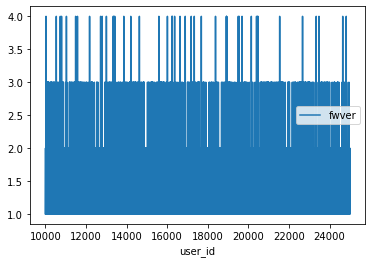

In [35]:
data = train_err[['user_id', 'fwver']].drop_duplicates()
data.groupby(data["user_id"]).count().plot()

- 중복제거를 하고 각 user_id당 출현한 fwver을 종합한 결과, 1개에서 4개의 fwver을 갖는 다는 것을 알았다.
- 여기서 가정을 하나 해보자면 2개 이상의 fwver을 갖는 user_id가 에러가 뜰 확률이 높다
- 그리고 이러한 user_id의 errtype이나 errcode를 확인해서 공통점을 발견할 수 있을 것이다.

### errtype

In [39]:
errtype_uniq = np.sort(train_err.errtype.unique())
errtype_uniq
for i in errtype_uniq:
    print("unique errcodes of errtype", i, ':\n', train_err.loc[train_err["errtype"] == i].errcode.unique())

unique errcodes of errtype 1 :
 ['0' 'P-44010' 'P-41011' 'P-41007 ' 'P-44010 ' 'P-41007' 'P-41011 '
 'P-41001']
unique errcodes of errtype 2 :
 ['1' '0']
unique errcodes of errtype 3 :
 ['1' '2' '0']
unique errcodes of errtype 4 :
 ['0' '1']
unique errcodes of errtype 5 :
 ['B-A8002' 'Q-64002' 'S-61001' 'U-81009' 'V-21008' '700001' 'S-64002'
 'J-30021' 'S-65002' 'Q-64001' 'H-51042' 'C-11017' 'H-51046' 'H-51049'
 'V-21002' 'V-21003' 'V-21004' 'V-21005' 'B-51042' 'M-99999' 'U-82024'
 'H-51048' '60045' 'U-82026' 'C-13053' 'C-14014' 'V-21010' 'J-20029'
 'J-30010' 'Y-00008' 'S-64000' 'En00409' 'E-59902' 'Q-73004' 'C-12032'
 'J-40011' 'U-82023' 'Q-73006' 'D-10011' 'S-65' 'M-51007' 'S-64001'
 'Y-00005' 'P_41007' '2638' 'CM a' nan '40013' 'D-99999' 'U-82004'
 'En00402' 'B-51049' 'C-11020' 'V-21007' 'M-51020' 'En00406' 'C-11087'
 'U-81000' 'Y-00004' 'C-13039' '0001' 'U-82020' 'http' 'P_41001' 'U-81014']
unique errcodes of errtype 6 :
 ['1' '14']
unique errcodes of errtype 7 :
 ['1' '14']
unique

#### errtype 과 errcode의 관계
- errtype과 errcode가 깔끔하게 분류되지는 않았다. 겹치는 errcode가 많았다.
- 가능한 파생변수를 생각해 보자면, 0과 1
- errcode 앞에 알파벳이 붙는지 (P, B, Q, S, U, C, H, J, E, En, Y, D, M, http) 등 각 알파벳을 한개의 파생변수로 할 수 있다.
- 한자리, 두자리, 세자리, 네자리, 다섯자리, 그 이상의 수 errcode로 파생변수 생성가능
- connection과 관련된 errcode를 묶어서 변수처리
- connection과 관련된 row들의 시간이 어떻게 형성되는지 분석해 볼 필요가 있다.
- 특이한 code: 'NFANDROID2' 근데 얘는 errtype 41 에만 존재한다.
- errtype의 value_counts 결과, errtype 23이 가장 많았고, 이 타입은 connection error류의 타입이다.
- 다음은 errtype 31인데 이는 errcode가 0과 1로만 되어있다.
- errtype 22는 errcode 1로만 구성된다.

In [47]:
train_err.errtype.value_counts()

23    2276515
31    1985294
22    1865361
15    1604951
4     1296750
16    1249376
32    1130564
5      952920
40     730378
28     544306
27     540804
26     536401
12     320181
11     307030
14     252015
33     178477
34     165536
10     133403
41     104138
7       51993
6       50482
17      46009
24      39071
42      34374
3       30758
2       26106
13      22843
1       21545
39      15820
35      10187
37       9336
36       9317
38       4539
18       2671
20       2080
25       1184
19        664
21        607
30        402
8         166
9         109
Name: errtype, dtype: int64

In [52]:
pd.set_option('display.max_rows',3000)
train_err.errcode.value_counts()

1                                          8906967
0                                          2599123
connection timeout                         1835600
B-A8002                                    897863 
80                                         334018 
79                                         332422 
14                                         263577 
active                                     219238 
2                                          166382 
84                                         129876 
85                                         127744 
standby                                    110370 
NFANDROID2                                 104138 
connection fail to establish               100940 
3                                          91223  
90                                         65992  
89                                         64799  
S-61001                                    34631  
95                                         23452  
94                             

#### errcode로 가능한 파생변수
- 1과 0
- connection out 류
- 알파벳 류
- 다른 word codes (active, standby, http, ...) 각 word를 하나의 column으로 설정
- 10번대 ~ 90번대
- 1000번대 ~ 9000번대
- 10000번 이상

In [46]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
errcode_type38 = train_err.loc[train_err["errtype"] == 38].errcode.unique()
np.sort(errcode_type38.astype(int))

array([   3001,    3002,    3003,    3004,    3005,    3006,    3007,    3008,    3009,    3010,    3011,    3012,    3013,    3014,    3015,    3016,    3017,    3018,    3019,    3020,    3021,    3022,    3023,    3024,    3025,    3026,    3027,    3028,    3029,    3030,    3031,    3032,    3033,    3034,    3035,    3036,    3038,    3039,    3040,    3041,    3042,    3043,    3044,    3045,    3046,    3047,    3048,    3049,    3050,    3051,    3052,    3053,    3054,    3055,    3056,    3057,    3058,    3059,    3060,    3061,    3062,    3063,    3064,    3065,    3066,    3067,    3068,    3069,    3070,    3071,    3072,    3073,    3074,    3075,    3076,    3077,    3078,    3079,    3080,    3081,    3082,    3083,    3084,    3085,    3086,    3087,    3088,    3089,    3090,    3091,    3092,    3093,    3094,    3095,    3096,    3097,    3098,    3099,    3101,    3102,    3103,    3104,    3105,    3106,    3107,    3108,    3109,    3110,    3111,    3112,    

- errtype 38 에는 다른 errtype과 다르게 2000개가 넘는 unique errcode 들이 존재했다. 이들은 모두 3001이상의 값이었고 최대값은 4875823 이었다. 하지만 이는 에러코드로서 명목변수에 지나지 않는다. 따라서 파생변수를 만들때 3000이상인지 에 대한 column을 추가할 수 있다.


In [53]:
errtype_uniq = np.sort(train_err.errtype.unique())
errtype_uniq
for i in errtype_uniq:
    print("unique user_id of errtype", i, ':\n', train_err.loc[train_err["errtype"] == i].user_id.unique())

unique user_id of errtype 1 :
 [10080 10092 10167 10168 10171 10206 10207 10217 10243 10263 10265 10268 10293 10298 10303 10323 10353 10370 10396 10398 10463 10468 10482 10491 10493 10496 10499 10501 10506 10515 10516 10531 10548 10557 10582 10598 10636 10648 10655 10662 10673 10696 10709 10720 10725 10740 10777 10800 10814 10819 10867 10874 10919 10920 10939 10940 10975 11002 11011 11021 11030 11037 11047 11049 11051 11057 11065 11075 11092 11103 11124 11125 11139 11156 11159 11165 11172 11179 11190 11227 11238 11288 11299 11306 11330 11334 11366 11386 11413 11432 11433 11450 11471 11477 11484 11491 11508 11525 11540 11559 11584 11587 11594 11613 11614 11630 11634 11659 11704 11705 11715 11719 11722 11729 11793 11794 11806 11817 11841 11858 11885 11890 11911 11917 11926 11927 11964 12006 12016 12024 12035 12043 12066 12105 12115 12131 12138 12144 12152 12156 12159 12187 12188 12199 12222 12236 12247 12251 12260 12265 12267 12268 12310 12417 12428 12438 12443 12465 12473 12478 12480 12

unique user_id of errtype 4 :
 [10000 10002 10004 10005 10006 10010 10011 10018 10019 10026 10027 10029 10030 10032 10035 10036 10037 10039 10041 10043 10049 10050 10051 10052 10053 10055 10057 10059 10060 10061 10067 10068 10069 10071 10072 10073 10075 10076 10078 10079 10080 10081 10084 10088 10089 10092 10094 10098 10100 10102 10105 10108 10110 10111 10114 10115 10118 10119 10122 10124 10126 10131 10134 10135 10136 10137 10141 10142 10146 10147 10148 10151 10155 10156 10157 10159 10167 10168 10171 10172 10173 10175 10177 10179 10181 10184 10185 10191 10193 10195 10196 10197 10202 10203 10204 10205 10206 10207 10208 10209 10212 10214 10215 10216 10217 10221 10223 10224 10225 10226 10231 10232 10233 10238 10239 10240 10241 10243 10244 10249 10251 10257 10260 10261 10262 10263 10265 10266 10267 10268 10273 10275 10276 10279 10280 10282 10285 10286 10287 10288 10289 10292 10293 10296 10298 10302 10303 10305 10306 10311 10313 10315 10322 10323 10325 10326 10327 10329 10333 10340 10349 10

 [10001 10002 10003 10005 10006 10009 10010 10011 10012 10014 10018 10019 10020 10021 10022 10023 10024 10025 10026 10027 10029 10030 10031 10032 10033 10035 10036 10037 10038 10039 10040 10041 10043 10046 10048 10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10060 10061 10062 10063 10065 10066 10067 10069 10071 10072 10073 10074 10075 10076 10077 10078 10079 10081 10082 10083 10084 10085 10086 10088 10089 10090 10093 10094 10098 10099 10100 10102 10103 10104 10105 10108 10110 10111 10112 10114 10115 10116 10117 10118 10119 10120 10122 10123 10124 10126 10127 10128 10129 10130 10131 10132 10133 10134 10135 10140 10141 10142 10145 10146 10147 10148 10149 10150 10151 10152 10153 10154 10155 10156 10157 10158 10159 10160 10161 10164 10165 10167 10168 10169 10172 10173 10174 10175 10176 10177 10178 10179 10181 10182 10184 10185 10187 10188 10189 10190 10191 10193 10194 10195 10196 10197 10198 10200 10202 10203 10205 10208 10209 10210 10211 10212 10214 10216 10217 10218 10219 10

 [10000 10002 10005 10013 10014 10020 10032 10035 10038 10045 10049 10050 10064 10065 10072 10079 10090 10092 10094 10107 10115 10122 10126 10134 10136 10144 10145 10152 10167 10174 10177 10185 10191 10205 10206 10207 10216 10217 10228 10251 10260 10265 10268 10271 10276 10278 10279 10281 10290 10298 10304 10313 10317 10345 10359 10363 10366 10373 10381 10383 10384 10390 10391 10395 10407 10423 10439 10442 10446 10454 10455 10461 10471 10483 10488 10490 10496 10502 10514 10526 10531 10533 10535 10542 10543 10554 10556 10563 10567 10569 10571 10576 10578 10581 10586 10600 10603 10609 10618 10622 10625 10630 10644 10659 10661 10669 10674 10682 10685 10687 10696 10698 10699 10700 10703 10706 10716 10722 10724 10736 10740 10743 10749 10752 10764 10772 10778 10784 10786 10787 10790 10792 10795 10803 10805 10812 10821 10822 10823 10824 10833 10834 10838 10839 10845 10847 10851 10857 10862 10867 10870 10871 10876 10877 10880 10887 10890 10891 10895 10917 10931 10933 10938 10940 10944 10952 10

unique user_id of errtype 12 :
 [10000 10001 10002 10003 10004 10005 10006 10007 10008 10009 10010 10011 10012 10013 10014 10015 10016 10017 10018 10019 10020 10021 10022 10023 10024 10025 10026 10027 10028 10029 10030 10031 10032 10033 10034 10035 10036 10037 10038 10039 10040 10041 10042 10043 10044 10045 10046 10047 10048 10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073 10074 10075 10076 10077 10078 10079 10081 10082 10083 10084 10085 10086 10088 10089 10090 10091 10092 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10114 10115 10116 10117 10118 10119 10120 10121 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10134 10135 10136 10137 10138 10139 10140 10141 10142 10143 10144 10145 10146 10147 10148 10149 10150 10151 10152 10153 10154 10155 10156 10157 10158 10159 10160 10161 10162 1

unique user_id of errtype 15 :
 [10000 10001 10002 10003 10004 10005 10006 10007 10008 10009 10010 10011 10012 10013 10014 10015 10017 10018 10019 10020 10021 10022 10023 10024 10025 10026 10027 10028 10029 10030 10031 10032 10033 10034 10035 10036 10037 10038 10039 10040 10041 10042 10044 10045 10046 10047 10048 10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073 10074 10075 10076 10077 10078 10079 10081 10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10092 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10114 10115 10116 10117 10118 10119 10120 10121 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10134 10135 10136 10137 10138 10139 10140 10141 10142 10143 10144 10145 10146 10147 10148 10149 10150 10151 10152 10153 10154 10155 10156 10157 10158 10159 10160 10161 10162 10163 10164 1

unique user_id of errtype 16 :
 [10000 10001 10002 10003 10004 10005 10006 10009 10010 10011 10012 10013 10014 10015 10017 10018 10019 10020 10021 10022 10023 10024 10025 10026 10027 10028 10029 10030 10031 10032 10033 10034 10035 10036 10037 10038 10039 10040 10041 10042 10044 10045 10047 10048 10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073 10074 10075 10076 10077 10078 10079 10081 10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10092 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10114 10115 10116 10117 10118 10119 10120 10121 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10134 10135 10136 10137 10138 10139 10140 10141 10142 10143 10144 10145 10146 10147 10148 10149 10150 10151 10152 10153 10154 10155 10156 10157 10158 10159 10160 10161 10162 10163 10164 10165 10166 1

 [10001 10014 10067 10079 10093 10102 10107 10119 10123 10125 10129 10130 10133 10140 10154 10160 10169 10173 10181 10188 10189 10190 10199 10202 10208 10209 10212 10247 10255 10260 10277 10280 10294 10300 10304 10327 10335 10339 10351 10364 10374 10379 10383 10390 10391 10392 10412 10417 10450 10454 10466 10529 10536 10559 10574 10590 10608 10618 10623 10625 10629 10634 10640 10661 10686 10701 10703 10706 10708 10732 10749 10754 10762 10764 10767 10771 10772 10778 10780 10790 10804 10816 10828 10830 10836 10845 10846 10851 10853 10854 10859 10887 10895 10902 10928 10930 10947 10974 10986 10995 11015 11021 11028 11045 11050 11054 11056 11062 11072 11077 11086 11106 11120 11136 11177 11184 11207 11222 11250 11261 11265 11266 11274 11279 11284 11293 11298 11300 11301 11310 11314 11320 11349 11350 11365 11387 11391 11394 11433 11440 11463 11475 11489 11498 11500 11525 11527 11533 11555 11560 11562 11571 11579 11586 11593 11602 11624 11625 11633 11636 11640 11645 11646 11657 11667 11679 11

unique user_id of errtype 22 :
 [10001 10003 10004 10005 10007 10008 10009 10010 10011 10012 10013 10014 10015 10017 10020 10021 10022 10023 10024 10025 10028 10029 10031 10033 10034 10038 10039 10040 10041 10042 10044 10045 10046 10047 10048 10050 10054 10055 10056 10058 10059 10061 10062 10063 10064 10065 10066 10067 10070 10073 10074 10075 10077 10078 10079 10081 10082 10083 10085 10086 10087 10090 10091 10093 10094 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10116 10117 10118 10119 10121 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10138 10139 10140 10143 10144 10145 10148 10150 10152 10153 10154 10158 10159 10160 10161 10162 10163 10164 10165 10166 10169 10172 10173 10174 10175 10176 10178 10179 10180 10181 10182 10183 10187 10188 10189 10190 10192 10194 10196 10197 10199 10200 10201 10202 10208 10209 10210 10211 10212 10213 10214 10215 10218 10219 10220 10222 10226 10227 10228 10229 10230 10232 1

unique user_id of errtype 23 :
 [10001 10003 10004 10005 10007 10008 10009 10010 10011 10012 10013 10014 10015 10017 10020 10021 10022 10023 10024 10025 10028 10029 10031 10033 10034 10038 10039 10040 10041 10042 10044 10045 10046 10047 10048 10050 10054 10055 10056 10058 10059 10061 10062 10063 10064 10065 10066 10067 10070 10073 10074 10077 10078 10079 10081 10082 10083 10085 10086 10087 10090 10091 10094 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10116 10117 10118 10119 10121 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10138 10140 10144 10145 10148 10150 10152 10153 10154 10158 10159 10160 10161 10162 10163 10164 10165 10166 10169 10172 10173 10174 10175 10176 10178 10179 10180 10181 10182 10183 10187 10188 10189 10190 10192 10194 10196 10197 10199 10200 10201 10202 10208 10209 10210 10211 10212 10213 10214 10215 10218 10219 10220 10222 10226 10227 10228 10229 10230 10232 10234 10235 10236 10237 1

unique user_id of errtype 26 :
 [10000 10001 10002 10003 10004 10005 10009 10010 10011 10012 10014 10015 10016 10017 10018 10019 10020 10021 10022 10023 10024 10025 10026 10027 10028 10029 10030 10031 10033 10034 10035 10036 10037 10038 10039 10040 10041 10042 10044 10045 10046 10047 10048 10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073 10074 10075 10076 10077 10078 10079 10081 10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10093 10094 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10114 10115 10116 10117 10118 10119 10121 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10134 10135 10136 10137 10138 10139 10140 10141 10142 10143 10144 10145 10146 10147 10148 10150 10151 10152 10153 10154 10155 10157 10158 10159 10160 10161 10163 10164 10165 10166 10169 10172 10173 10174 10175 10176 10178 10179 1

unique user_id of errtype 28 :
 [10000 10002 10005 10019 10032 10047 10049 10074 10079 10080 10081 10090 10092 10094 10134 10144 10151 10166 10167 10168 10171 10173 10174 10191 10193 10195 10203 10205 10206 10207 10217 10218 10229 10243 10246 10249 10259 10260 10263 10265 10268 10271 10273 10277 10279 10288 10290 10293 10298 10301 10313 10323 10328 10345 10359 10361 10363 10364 10370 10372 10373 10383 10385 10390 10393 10396 10398 10400 10404 10407 10427 10438 10439 10446 10447 10450 10453 10454 10455 10463 10467 10468 10469 10475 10476 10480 10485 10488 10490 10491 10496 10499 10501 10515 10516 10523 10527 10531 10533 10539 10542 10548 10554 10557 10563 10567 10569 10570 10581 10582 10586 10598 10603 10606 10632 10633 10636 10643 10648 10662 10671 10673 10674 10681 10696 10709 10711 10716 10722 10724 10725 10736 10737 10738 10740 10743 10749 10758 10764 10779 10785 10790 10800 10814 10816 10817 10819 10822 10828 10831 10833 10845 10857 10865 10867 10869 10874 10877 10880 10891 10892 1

unique user_id of errtype 31 :
 [10001 10003 10004 10005 10006 10009 10010 10011 10012 10013 10014 10015 10017 10020 10021 10022 10023 10024 10025 10028 10029 10031 10032 10033 10034 10038 10039 10040 10041 10042 10044 10045 10046 10047 10048 10050 10054 10055 10056 10058 10059 10061 10062 10063 10064 10065 10066 10067 10070 10073 10074 10075 10077 10078 10079 10081 10082 10083 10085 10086 10087 10090 10091 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10116 10117 10118 10119 10120 10121 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10138 10139 10140 10143 10144 10145 10148 10149 10150 10152 10153 10154 10156 10158 10159 10160 10161 10162 10163 10164 10165 10166 10169 10170 10172 10173 10174 10175 10176 10177 10178 10179 10180 10181 10182 10183 10186 10187 10188 10189 10190 10192 10194 10196 10197 10198 10199 10200 10201 10208 10209 10210 10211 10212 10213 10214 10215 10218 10219 10220 1

unique user_id of errtype 33 :
 [10001 10003 10004 10005 10006 10007 10008 10009 10010 10011 10012 10013 10014 10015 10017 10020 10021 10022 10023 10024 10025 10028 10029 10031 10032 10033 10034 10038 10039 10040 10041 10042 10044 10045 10046 10047 10048 10050 10054 10055 10056 10058 10059 10061 10062 10063 10064 10065 10066 10067 10070 10073 10074 10075 10077 10078 10079 10081 10082 10083 10085 10086 10090 10091 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10116 10117 10118 10119 10120 10121 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10138 10139 10140 10143 10144 10145 10148 10149 10150 10152 10153 10154 10156 10158 10159 10160 10161 10162 10163 10164 10165 10166 10169 10170 10172 10173 10174 10175 10176 10177 10178 10179 10180 10181 10182 10183 10186 10187 10188 10189 10190 10192 10194 10196 10197 10198 10199 10200 10201 10208 10209 10210 10211 10212 10213 10214 10215 10218 10219 1

unique user_id of errtype 37 :
 [10001 10003 10004 10005 10006 10007 10008 10011 10012 10013 10014 10015 10017 10020 10022 10023 10024 10025 10028 10029 10031 10033 10034 10038 10040 10042 10044 10045 10047 10048 10050 10054 10055 10056 10058 10059 10062 10063 10064 10065 10066 10067 10070 10073 10074 10075 10077 10079 10081 10082 10083 10085 10086 10091 10093 10095 10096 10097 10099 10100 10101 10102 10103 10104 10105 10106 10109 10110 10112 10113 10116 10117 10118 10119 10120 10121 10123 10124 10125 10128 10129 10130 10131 10132 10133 10138 10139 10143 10144 10145 10148 10149 10150 10153 10154 10156 10159 10160 10162 10163 10166 10169 10172 10173 10174 10176 10177 10178 10180 10181 10182 10183 10186 10187 10189 10190 10192 10198 10199 10200 10201 10208 10210 10211 10212 10213 10218 10219 10220 10222 10226 10227 10228 10229 10234 10235 10237 10242 10245 10246 10247 10248 10253 10255 10256 10257 10258 10259 10260 10264 10269 10270 10271 10272 10275 10276 10277 10280 10281 10283 10284 1

unique user_id of errtype 40 :
 [10001 10003 10004 10005 10006 10009 10010 10011 10012 10013 10014 10015 10017 10020 10021 10022 10023 10024 10025 10028 10029 10031 10032 10033 10034 10038 10039 10040 10041 10042 10044 10045 10047 10048 10050 10054 10055 10056 10058 10059 10061 10062 10063 10064 10065 10066 10067 10070 10073 10074 10075 10077 10078 10079 10081 10082 10083 10085 10086 10087 10090 10091 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10109 10110 10111 10112 10116 10117 10119 10120 10121 10123 10124 10125 10126 10127 10128 10129 10130 10131 10133 10138 10139 10140 10143 10144 10145 10149 10150 10152 10153 10154 10156 10158 10159 10160 10161 10162 10163 10164 10165 10166 10169 10172 10173 10174 10175 10176 10177 10178 10179 10180 10181 10182 10186 10187 10188 10189 10190 10192 10194 10196 10197 10198 10199 10200 10201 10208 10209 10210 10211 10212 10213 10214 10215 10218 10219 10220 10222 10226 10227 10228 10229 10230 10232 10234 1

In [54]:
id_uniq = np.sort(train_err.user_id.unique())
for i in id_uniq:
    print("unique errtype of user_id", i, ':\n', train_err.loc[train_err["user_id"] == i].errtype.unique())

unique errtype of user_id 10000 :
 [15 12 11 16  4 26 10 14  3 13  6  7 27 28]
unique errtype of user_id 10001 :
 [15 31 33 12 11 22 26 16 41  5 14 40 34 13  6  7 37 36 23 18 20 19 21 42 24 25]
unique errtype of user_id 10002 :
 [11 12 16  4 26 15 24 27 28 13  3  7  6 14  5 10]
unique errtype of user_id 10003 :
 [15 16 31 40 22 23 26  6  7  5 17 38 33 12 11 37 36 41]
unique errtype of user_id 10004 :
 [13 12 14  6  7 15 33 11 22 26 16 31 23 40  4 37 36 42]
unique errtype of user_id 10005 :
 [26 15 16 31 41  5 23 22 40 33 11 12 24  4 34 39  7 10 14 35 28 27 36 37 42]
unique errtype of user_id 10006 :
 [15 16 31 17 33 11 12  5 34 35  6  7 14  4 36 37 40]
unique errtype of user_id 10007 :
 [15 33 12 11 22 23 36 37 42]
unique errtype of user_id 10008 :
 [15 33 22 12 11 36 37 23 42]
unique errtype of user_id 10009 :
 [16 31 15 23 22 26 32 33 11 12 17  5 40 41 34]
unique errtype of user_id 10010 :
 [26 23 22 16 31 15 33 11 12  5 17 32 41  4 40]
unique errtype of user_id 10011 :
 [22 26 16 31

unique errtype of user_id 10107 :
 [31 33 40 15 12 11 10 14  7  6 13 32 16 17 25 34 22 18 20 26 39 23 41]
unique errtype of user_id 10108 :
 [26 15 16 31 33 22 12 11 23 17  5 14  7 38  4]
unique errtype of user_id 10109 :
 [33 15 12 11 22 26 16 31 40 23 41  7  6 36 37 42]
unique errtype of user_id 10110 :
 [15 26 16 31 40 33 22 11 12 23  5 38  4  7 17 35 34 36 37]
unique errtype of user_id 10111 :
 [26 40 34 15 16 31 33 11 12 22 17  5 23 41 38 24  4]
unique errtype of user_id 10112 :
 [13 12 14 26 16 31 40 15 39 33 11 22 23 41 37 36 42  5 34 17]
unique errtype of user_id 10113 :
 [23 22 16 33 37 36 31 12 11]
unique errtype of user_id 10114 :
 [11 12 15 26  4 16  5  6]
unique errtype of user_id 10115 :
 [12 11  5  4 16 26 15  7 14  6 10  3]
unique errtype of user_id 10116 :
 [15 33 31 11 12 22 16 26 40 41 34  5 36 37 23 42 13 14  6  7]
unique errtype of user_id 10117 :
 [15 31 16 23 22 26 33 11 12 34 17 40 37 36  5 42]
unique errtype of user_id 10118 :
 [26  5 41 15 16 31 33 11 12 22 13

unique errtype of user_id 10214 :
 [33 31 15 11 12 22 26 16 17  5 23  4 40  7 32 39]
unique errtype of user_id 10215 :
 [32 26 16 31 23 15 34 33 22 11 12 38 40  4]
unique errtype of user_id 10216 :
 [16 26  4 15 11 12  5  6 14  7 10  3]
unique errtype of user_id 10217 :
 [ 1  4 12 11 15 16 17  6  5 28 27  3 10]
unique errtype of user_id 10218 :
 [26 15 40 33 11 12 22 16 31 23 34  6  5 17 27 28  7 14 13 37 36 42 41]
unique errtype of user_id 10219 :
 [22 23 26 16 15 40 31 33 12 11 34  5 41 17 37 36 42 14  6]
unique errtype of user_id 10220 :
 [15 33 11 12 22 26 16 31 40  7 23 36 37 42]
unique errtype of user_id 10221 :
 [ 4 12 11  5  3 13  7  6 14 26 15 16]
unique errtype of user_id 10222 :
 [15 31 33 12 11 22 26 16 40  5 37 36 23 42]
unique errtype of user_id 10223 :
 [11 12 16 26  4 15  5  3 13 14  6  7]
unique errtype of user_id 10224 :
 [16 26  4 15 12 11  5 14  6  7  3 13]
unique errtype of user_id 10225 :
 [26 15 16  4 11 12  5 13  3  7  6 14 18]
unique errtype of user_id 10226 :


unique errtype of user_id 10322 :
 [ 4 11 12 26]
unique errtype of user_id 10323 :
 [ 1 16  4 28 27 15 11 12  7  6 14]
unique errtype of user_id 10324 :
 [15 26 16 31 40 41 33 12 11 22 37 36 23 42  5]
unique errtype of user_id 10325 :
 [26 15  4 16 11 12  5 13  3 14  7  6]
unique errtype of user_id 10326 :
 [11 12 16  4 26 15  5 14 17]
unique errtype of user_id 10327 :
 [23 22 15 33 12 11 26 16 31 40  5  6  7 14  4 37 36 18 25 20 41 42]
unique errtype of user_id 10328 :
 [26 15 33 11 12 22 16 31  5 17 27 28 35 40  7 23 36 37]
unique errtype of user_id 10329 :
 [26 15 16 31 23 22 40  5 33 11 12 34 41  4 37 36 42]
unique errtype of user_id 10330 :
 [33 12 11 15 16 31 40 36 37]
unique errtype of user_id 10331 :
 [31 15 33 12 11 22 26 16 40 14 35  7 36 37 23 42]
unique errtype of user_id 10332 :
 [15 31 33 36 37 11 12 22 16 26 23  5 41 42 40  7 14  6 34]
unique errtype of user_id 10333 :
 [23 22 16 26 31 15 33 12 11  4  5 24 37 36 42 40 41]
unique errtype of user_id 10334 :
 [11 12  5 14]


unique errtype of user_id 10426 :
 [33 16 12 11 30]
unique errtype of user_id 10427 :
 [23 22 15 33 31 12 11 26 16 40 41  5 34 36 37 42 28 27 35]
unique errtype of user_id 10428 :
 [15 33 31 11 12 22 16 26 40 41 23 37 36 42 14  5]
unique errtype of user_id 10429 :
 [26 15 16 31 40 33 12 11 22 41 14 36 37 23 42  5]
unique errtype of user_id 10430 :
 [ 4 11 12 16 26 15 17  5]
unique errtype of user_id 10431 :
 [33 11 12 22 31 26 15 16 40 23 42 41  5 34 17 14  7  6]
unique errtype of user_id 10432 :
 [ 4 11 12 16 26 15  5]
unique errtype of user_id 10433 :
 [26 16 31 15 33 11 12 22 40 23 41  7 38 36 37  5 42 39]
unique errtype of user_id 10434 :
 [26 16 31 23 22 15 40 33 12 11 36 37 42  5 41]
unique errtype of user_id 10435 :
 [33 31 16 11 12 34 30]
unique errtype of user_id 10436 :
 [15 33 31 12 11 14  7  6 16  5 40 34 37 36 35]
unique errtype of user_id 10437 :
 [31 33 15 12 11 22 26 16 17 40 41 23 24 34  5 37 36 42]
unique errtype of user_id 10438 :
 [33 11 12 22 31 26 15 16 40 23 28  

unique errtype of user_id 10535 :
 [15 16 26  4 17 12 11 10  3  6  7 14  5 13]
unique errtype of user_id 10536 :
 [31 33 15 12 11 22 26 16 17  5 23 40 19 21 18 20 37 36 42 41 34]
unique errtype of user_id 10537 :
 [31 33 16 22 26 11 12 23 40  5 15 17 38  4 14]
unique errtype of user_id 10538 :
 [26 15 16 31 33 12 11 22 40 23  4 37 36 42]
unique errtype of user_id 10539 :
 [15 12 11  4 26 16 24 13  3 14 27 28  6  7  5]
unique errtype of user_id 10540 :
 [31 15 16 33 12 11 40  5 17 35  6  7 38 36 37 14]
unique errtype of user_id 10541 :
 [31 15 33 12 11 22 26 16 40 41 36 37 23 42  5]
unique errtype of user_id 10542 :
 [33 31 16 22 12 11 26 15 14 10 23 40  6  7 27 28 35 13 34 17 36 37]
unique errtype of user_id 10543 :
 [26 16 31 15 40 33 12 11 22 37 36 23 42  6 14  7 13 10]
unique errtype of user_id 10544 :
 [16  4 26 15 12 11  5  7 14  3]
unique errtype of user_id 10545 :
 [ 6  7 16 26 31 23 15 33 12 11 22 14 17  5]
unique errtype of user_id 10546 :
 [33 31 15 11 12 32 16 17  5 40 41  4

unique errtype of user_id 10636 :
 [23 22 26 31 15 16 33 12 11 40 17  5  4 27 28 14 38 35  1 24]
unique errtype of user_id 10637 :
 [31 33 16 11 12 22 26 15 40 23 37 36 41]
unique errtype of user_id 10638 :
 [11 12  3 13 14  5 16  4 26 15]
unique errtype of user_id 10639 :
 [15 11 12 16  4 26  5]
unique errtype of user_id 10640 :
 [33 36 37 31 11 12 18 20 26  5 15 40 16 23 22  8 42]
unique errtype of user_id 10641 :
 [26 40 15 33 31 12 11 22 16  5 23 34 36 37  7 42 41]
unique errtype of user_id 10642 :
 [15  4 16 26 11 12  5]
unique errtype of user_id 10643 :
 [16 26  4 15 12 11 13  3 14  6  7  5 27 28 17]
unique errtype of user_id 10644 :
 [22 23 15 31 33 11 12 26 16 40 17  5 10 14 34 24 41  4]
unique errtype of user_id 10645 :
 [26 31 16 15 40 33 11 12 22 36 37 23 42 13  7 14]
unique errtype of user_id 10646 :
 [15 33 31 12 11 22 26 16 41 40 36 37 23 42 17 14  5]
unique errtype of user_id 10647 :
 [ 4 12 11 15 26 16  5]
unique errtype of user_id 10648 :
 [ 1  4 11 12 28 27 16 15  3]


unique errtype of user_id 10747 :
 [15 40 33 31 11 12 22 26 16 23  5 37 36 42 41 14  7  6]
unique errtype of user_id 10748 :
 [26 16 31 23 22 15 34 40 33 11 12  4 37 36  5 39 24 42  7 41]
unique errtype of user_id 10749 :
 [31 15 32 16 33 11 12 17  5 10 14 13 27 28  6  7 40 41  4 37 36 30 25 23 18 20 26 22 42 34]
unique errtype of user_id 10750 :
 [26 40 15 22 16 31 33 11 12 23 34 36 37  5 17 41 39 42]
unique errtype of user_id 10751 :
 [23 22 26 15 32 31 16 41 33 11 12 17  5 34  4 25 37 36 40 14  6]
unique errtype of user_id 10752 :
 [26 15 16  4 11 12  5 14 10  3  6]
unique errtype of user_id 10753 :
 [33 11 22 12 26 23 40 16 36 37 31]
unique errtype of user_id 10754 :
 [37 33 36 12 11 34  7  6 13 14 16 15 31 40 41 18 20 26 42 22 23  5]
unique errtype of user_id 10755 :
 [16 26 17  5 31 15 33 12 11 22 23 40 13  7  6 14 32]
unique errtype of user_id 10756 :
 [16  4 26 15 12 11  7  3  6 13 14  5]
unique errtype of user_id 10757 :
 [15 16 31 40 33 12 11 36 37 41  7]
unique errtype of us

unique errtype of user_id 10850 :
 [33 31 15 12 11 22 26 16 17 40 23 41 32  5  6  7]
unique errtype of user_id 10851 :
 [26 16 31 15 40 33 11 12 22 23 14  6  7 38 17  5 37 36 10 42 35 18 20]
unique errtype of user_id 10852 :
 [16 26  4 15 12 11  5]
unique errtype of user_id 10853 :
 [33 31 12 11 22 26 15 16 40 23 19 21 18 25 20 38  5 17]
unique errtype of user_id 10854 :
 [26  5 15 33 12 11 22 16 31  2 17 40 35 23 38 18 20 39  4 36 37]
unique errtype of user_id 10855 :
 [33 31 15 22 11 12 26 16 17  5 40 23 41 34 14]
unique errtype of user_id 10856 :
 [26 41 15 33 22 11 12 16 31 23 40 14  7  6 36 37 42]
unique errtype of user_id 10857 :
 [16  4 26 15 11 12  5 14  7 27  6 28 13  3 10]
unique errtype of user_id 10858 :
 [33 15 11 12 22 26 16 31 23 13 14  6  7 40 37 36]
unique errtype of user_id 10859 :
 [23 22 26 15 40 16 31 41 33 11 12  5 18 20 30 37 36 14]
unique errtype of user_id 10860 :
 [26 16 31 15 23 22 40 33 11 12  5  4  7 14 36 37 42]
unique errtype of user_id 10861 :
 [16  4 26

unique errtype of user_id 10946 :
 [26 40 15 16 31  5 33 11 12 22 23 37 36 42 24 41]
unique errtype of user_id 10947 :
 [15 16 31 40 25 33 12 11  5 17 36 37 32 22 18 20 26 23]
unique errtype of user_id 10948 :
 [33 15 31 11 12 22 37 36 23 42 26 16]
unique errtype of user_id 10949 :
 [23 22 31 33 16 12 11 26 15  5 41 40 37 36]
unique errtype of user_id 10950 :
 [23 22 15 16 31 40 26 41]
unique errtype of user_id 10951 :
 [11 12 16  4 26 15 13  3 14  7  6  5]
unique errtype of user_id 10952 :
 [26 15 33 31 22 11 12 16 17  5 23 14 38 10 41 40 34]
unique errtype of user_id 10953 :
 [15 16 31 33 12 11 22 26 40 34 41 23 13 14  7  6 37 36 42]
unique errtype of user_id 10954 :
 [ 5 26 15 16 31 40 33 11 12 22 35 23 28  7  6 14 37 36 42]
unique errtype of user_id 10955 :
 [40 15 16 31 33 11 12 42 41  4  2  5 37 36 34 13 14  7  6]
unique errtype of user_id 10956 :
 [31 33 16 12 11 22 26 40 15 36 37 23 24 17]
unique errtype of user_id 10957 :
 [15 16 31 26 33 12 11 22 40 23 36 37 42]
unique errtyp

unique errtype of user_id 11050 :
 [33 31 11 12 22 26 23  4 16  5 40 32 34 15  9 36 37 10 18 20 41 42]
unique errtype of user_id 11051 :
 [ 1 11 12  4 27 28 16 15  3]
unique errtype of user_id 11052 :
 [15 33 11 12 14  6  7 31 13 37 36]
unique errtype of user_id 11053 :
 [33 11 12 22 31 26 15 16 23 13  7  6 14 17  5]
unique errtype of user_id 11054 :
 [15 33 31 12 11 22 34 26 16  5 41 40 23 14 37 36 42 39 17 19 21 18 20]
unique errtype of user_id 11055 :
 [16 31 26 15 23 22 33 11 12  5 17 40 14  7  6 24 36 37 42]
unique errtype of user_id 11056 :
 [15 33 31 12 11 22 26 16 40 41 23 36 37 42 34 14 25 18 20  5]
unique errtype of user_id 11057 :
 [26 15 32 31 33 11 22 12 13 14  6  7 16 17  5 40 23 34 41  1]
unique errtype of user_id 11058 :
 [16 31 15  5 32 23 22 26 33 12 11 14 40 13  7  6 35 38 37 36 42]
unique errtype of user_id 11059 :
 [31 26 14 15 16 33 11 12 22  4 35  7  6 10 40 37 36 23 41 42]
unique errtype of user_id 11060 :
 [11 12 16 26 15  4 18 10  7  3  6 27 28 14]
unique errt

unique errtype of user_id 11158 :
 [15 33 31 12 11 22 26 16 40 23 41 37 36 42  5 17 13  6  7 14]
unique errtype of user_id 11159 :
 [15 16 28  4 27  1 11 12  3]
unique errtype of user_id 11160 :
 [26 15 16 31 33 12 11 22 40 23  4  5 37 36 42 34 10 13 14  6  7 27 28]
unique errtype of user_id 11161 :
 [26 16 31 41 15 33 22 11 12  5 17 23 24 40 10 34  7 37 36]
unique errtype of user_id 11162 :
 [15 32 16 31 40 33 12 11 17  5  7]
unique errtype of user_id 11163 :
 [16 26 15  4 11 12  5 14  7  6 17]
unique errtype of user_id 11164 :
 [26 15 22 16 31 40 23 33 11 12 14 37 36  5 42]
unique errtype of user_id 11165 :
 [24 11 12 10 14  3  7 15  4 16 26 27 28  5  6 30 33 31 22 23 41 40  1]
unique errtype of user_id 11166 :
 [ 4 16 26 15 11 12  5]
unique errtype of user_id 11167 :
 [26 15 16 31 22 23  5 17 40 33 12 11 34 37 36 42 38 41 24 14  7  6 35]
unique errtype of user_id 11168 :
 [26 40 23 22 15 16 31 33 11 12 24 41  7  4 36 37]
unique errtype of user_id 11169 :
 [26 15 40 16 31 23 22 33 11

unique errtype of user_id 11266 :
 [33 32 12 11 22 15 26 16 17  5 31 23 40 27 28 14  6  7 35 10 13 37 36 18 20 42]
unique errtype of user_id 11267 :
 [26 15 16 31 40 33 36 37 11 12 22]
unique errtype of user_id 11268 :
 [12 11  5  6]
unique errtype of user_id 11269 :
 [15 16 31 40 23 22 26 33 11 12 41 14  7 37 36 42]
unique errtype of user_id 11270 :
 [26 15 16  4 11 12  5 14  3 10 13  7  6 28 27]
unique errtype of user_id 11271 :
 [11 12  7 14  4  5  6]
unique errtype of user_id 11272 :
 [11 12  5  4 16 26 15]
unique errtype of user_id 11273 :
 [22 26 16 31 15 40 33 12 11 23 41 37 36 42 14  7  6 13 34 35]
unique errtype of user_id 11274 :
 [14 15 33 12 11 16 22 26 31 40 34 13  7  6 23 41  5 36 37 21 19 18 25 42 20]
unique errtype of user_id 11275 :
 [31 33 16 11 12 22 26 40 41  5 15 23 37 36 14 38 34 42]
unique errtype of user_id 11276 :
 [15 33 11 12 22 26 16 31 40 23 37 36  5 17 14  6 13  7]
unique errtype of user_id 11277 :
 [15 16 31 33 12 11 37 36  5]
unique errtype of user_id 11

unique errtype of user_id 11372 :
 [15 16 31 23 22 26 33 12 11 40 34 36 37 27 28 35  5 17 14 10  6  7 13 42]
unique errtype of user_id 11373 :
 [26 15 12 11 16  3 13  6  7 14  5  4 30]
unique errtype of user_id 11374 :
 [26 15 16 31 40 23 33 11 12 32 22 41 17  5 14  6  7 38]
unique errtype of user_id 11375 :
 [33 12 11 31 15 34 16 40 36 37 18 25 23]
unique errtype of user_id 11376 :
 [13 12  3 10 11 16 26  4 15  5 30 18 14  7  6]
unique errtype of user_id 11377 :
 [33 31 15 12 11 22 26 16 17  5 40 23]
unique errtype of user_id 11378 :
 [31 33 16 22 11 12 26 34 15 23 40 13  6 35  7 14 36 37 42]
unique errtype of user_id 11379 :
 [26  4 12 11  5]
unique errtype of user_id 11380 :
 [40 23 22 15 16 31  5  4 33 12 11 26  7 39 24 13  6 14 37 36 42]
unique errtype of user_id 11381 :
 [33 15 11 12 16 31 40 34 37 36]
unique errtype of user_id 11382 :
 [15 16  4 13 12  3 14  6  7 11  5 26 17]
unique errtype of user_id 11383 :
 [26 41 15 16 31  5 40 33 12 11 22  4 17 39 37 36 23 42 24]
unique err

unique errtype of user_id 11480 :
 [11 12 15 14 10  3  5  6]
unique errtype of user_id 11481 :
 [26 23 22 34 15 16 31 33 11 12 13 14  7  6  5 37 36 42 40 27 28]
unique errtype of user_id 11482 :
 [31  5 40 41  6 38 17  7]
unique errtype of user_id 11483 :
 [26 15 16  4 12 11  5]
unique errtype of user_id 11484 :
 [ 1  4 12 11 17 28 27 15 16 14  7  6]
unique errtype of user_id 11485 :
 [26 16 31 40  5 15 23 34 33 22 12 11 17  4 35]
unique errtype of user_id 11486 :
 [11 12  5  4 16 26 15]
unique errtype of user_id 11487 :
 [33 12 11 15 40 36 37 16]
unique errtype of user_id 11488 :
 [33 15 12 11 22 16 26 31 23  5 34 40  4 36 37]
unique errtype of user_id 11489 :
 [26 15 31 33 16 22 11 12 23  5 40 17  4 37 36 32 34 25 13  6  7 35 14 18 20 38 42]
unique errtype of user_id 11490 :
 [11 12 16 26  4 15  5 27 28 24  6 14  7  3 13]
unique errtype of user_id 11491 :
 [26  5 17 31 33 16 22 11 12 15 32 23  4 40  1  7 34 39 24 38 14 35  6 41]
unique errtype of user_id 11492 :
 [26 16 40 31 23 22 1

unique errtype of user_id 11586 :
 [15 33 12 11 22 16 26 31 24 23 41 40  6  7  5  4 36 37 18 20 19 21 42]
unique errtype of user_id 11587 :
 [12 11  4  1 15  5  3 14  7]
unique errtype of user_id 11588 :
 [33 14  5 12 26 40 15 16 31 22 11 17 10 38 36 37 23  7 27 28 41 35 13]
unique errtype of user_id 11589 :
 [26 33 31 15 12 11 22 16  4 17  5 23 32  6  7 14 24]
unique errtype of user_id 11590 :
 [15 33 11 12 16 31 40  4 36 37]
unique errtype of user_id 11591 :
 [23 22 31 33 15 12 11 16 26 41 40  5 13  7 14  6 37 36 42]
unique errtype of user_id 11592 :
 [26 41 15 16 31 40 33 11 12 22 34 37 36 23 42  5 14  6]
unique errtype of user_id 11593 :
 [41 15 33 22 12 11 26 16 31 34 23 40  6  7 14 13 10  4 24 18 20 37 36 42  5]
unique errtype of user_id 11594 :
 [15 16  1  4 27 28 12 11]
unique errtype of user_id 11595 :
 [33 15 11 12 22 26 16 31 40 23 41 37 36 42 34 13]
unique errtype of user_id 11596 :
 [26 16 15 31 33 12 22 11 17  5 23 40 13  6  7 14]
unique errtype of user_id 11597 :
 [15 31

unique errtype of user_id 11691 :
 [22 26 16 31 40 15 33 12 11 23 37 36 42 41  5]
unique errtype of user_id 11692 :
 [15 33 11 12 22 23 26 16 31 36 37 42 40 14]
unique errtype of user_id 11693 :
 [26 16 31 40 15 22 23 33 12 11 41  5 36 37]
unique errtype of user_id 11694 :
 [26 15 31 33 11 12 22 16 40 37 36 23 42  5]
unique errtype of user_id 11695 :
 [22 16 26 31  5 17 15 33 12 11 40 23 36 37 42 41]
unique errtype of user_id 11696 :
 [23 22 26 15 16 31 40 33 11 12 17  5 34]
unique errtype of user_id 11697 :
 [31 33 15 22 12 11 26 16 17  5 24 23 34 18 20 40  4 14]
unique errtype of user_id 11698 :
 [16 26  4 15 11 12  5]
unique errtype of user_id 11699 :
 [26 16 31 15 41 33 12 11 22 40 23  7 37 36 42  2]
unique errtype of user_id 11700 :
 [33 31 15 11 12 22 26 16 17  5 23 41 30 40 13  7  6 14 18 20]
unique errtype of user_id 11701 :
 [33 31 15 12 11 22 26 16 17  5 23 34  4]
unique errtype of user_id 11702 :
 [14 33 31 15 11 12 22 32 23 26 16 17  5 40 38 13  6  7 34 35 19 21 25 27 28 10

unique errtype of user_id 11798 :
 [31 15 16 34 33 11 12 40 41 25 22 18 20 26 39 23  4  5 37 36 19 21 42]
unique errtype of user_id 11799 :
 [26 15 31 40 22 16 33 12 11 23  5 36 37 42 17 27 28 35]
unique errtype of user_id 11800 :
 [15 33 11 12 22 16 26 31 40  6  7 13 14  5 41 23 36 37 38 42 17]
unique errtype of user_id 11801 :
 [ 4 16 26 15 12 11 14  6  7  5]
unique errtype of user_id 11802 :
 [15 33 22 12 11 34 26 16 31  5 23 24 41 40 37 36 42]
unique errtype of user_id 11803 :
 [26 16 31 15 23 33 22 11 12 34 40 17  5 18 20 41 38]
unique errtype of user_id 11804 :
 [15 33 31 11 12 22 26 16 40 41 32 36 37 23  7 42 35  5 17]
unique errtype of user_id 11805 :
 [26 15 22 16 31 33 11 12 40  5 41 32 23 37 36 14 42]
unique errtype of user_id 11806 :
 [ 1 16  4 15 28 27 12 11 10 14 17  3  5]
unique errtype of user_id 11807 :
 [ 4 26 12 11 15 16  5 10 14  6  7  3 27 28]
unique errtype of user_id 11808 :
 [16  4 26 15 12 11  5 14  6  7  8]
unique errtype of user_id 11809 :
 [33 31 15 11 12 22

unique errtype of user_id 11904 :
 [26 16 31 15 33 22 12 11  5 17 23 40  6 37 36]
unique errtype of user_id 11905 :
 [15 33 31 12 11 22 16 26 40  5 41 23 34 36 37 42  7]
unique errtype of user_id 11906 :
 [26 40 41  5 31 15 16 32 33 22 12 11 17 36 37 18 20 14 23 42  6  7]
unique errtype of user_id 11907 :
 [26  5 15 33 12 11 22 16 31 40 41  7 14  6  4 23 37 36]
unique errtype of user_id 11908 :
 [26 15 16 31 40 33 11 12 22 17  5 23 32 36 37 42 41  6 14 35  7 13 38]
unique errtype of user_id 11909 :
 [15 33 22 11 12 26 16 31 23  5 17 40 24 36 37 42]
unique errtype of user_id 11910 :
 [26 16 31 32 23 22 15 33 12 11 17  5 40  7 13  6 14]
unique errtype of user_id 11911 :
 [ 1  4 11 12 17 28 27  5 15 16]
unique errtype of user_id 11912 :
 [31 15 33 11 12 22 26 16 40  5 23  2 37 36 41 42]
unique errtype of user_id 11913 :
 [26 15 16 31 33 11 12 22 40 34 37 36 23 42 24 39 41]
unique errtype of user_id 11914 :
 [16 26 31 15 40 33 12 11 22 41  5  7 14  2  4 37 36 23 42]
unique errtype of user_

unique errtype of user_id 12012 :
 [26 16 31 40 15 33 11 12 22 41 23  4  7 18 20 36 37 42  5]
unique errtype of user_id 12013 :
 [26 15 33 31 12 11 22 16 40 36 37 23 42  5 24]
unique errtype of user_id 12014 :
 [26 15 32 16 31 23 40 33 22 11 12 17  5 38 13  7 14  6 37 36 34]
unique errtype of user_id 12015 :
 [ 4 12 11  5 14 10  3 13  6  7 15]
unique errtype of user_id 12016 :
 [ 4 27 28  1 12 11 15 16 17  3]
unique errtype of user_id 12017 :
 [23 22 42 31 15 33 11 12 16 26 40 17 13  7  6 14 41  5]
unique errtype of user_id 12018 :
 [26 15 33 11 12 22 16 31  5 23  2 40  4 37 36 42  7  6 14]
unique errtype of user_id 12019 :
 [31 33 15 22 16 11 12 26 23 32 40]
unique errtype of user_id 12020 :
 [11 12 16  4 26 15  5]
unique errtype of user_id 12021 :
 [26 15 16 31 33 22 12 11  5 23 40  7 14  6 18 25 20 37 36 35 27 28 42]
unique errtype of user_id 12022 :
 [15 22 16 26 31 40 33 12 11 23 34 36 37 42  7 21 19 18 20  5 41 14]
unique errtype of user_id 12023 :
 [15 33 12 11 22 26 16 31  4 40

unique errtype of user_id 12120 :
 [32 33 31 15 11 12 22 26 16 17  5 23 41 40 38 34]
unique errtype of user_id 12121 :
 [16 26  4 15 12 11  5]
unique errtype of user_id 12122 :
 [26 40 15 31 16 33 12 11 22 41  5 23 36 37 42]
unique errtype of user_id 12123 :
 [33 15 11 12 22 26 16 40 31 36 37 23 42]
unique errtype of user_id 12124 :
 [26 15 40 16 31 33 11 12 22 23 13  6 14  7  4 37 36 42]
unique errtype of user_id 12125 :
 [33 15 31 11 12 16 40 41  6  7 14  5]
unique errtype of user_id 12126 :
 [37 36 33 31 11 12  7 14  6 18 20 13 35  5 15 40 16 34 41 23 22 39 26 42]
unique errtype of user_id 12127 :
 [31 15 33 12 11 22 23 16 26  5 40 36 37 42]
unique errtype of user_id 12128 :
 [16 40 31 15 33 12 11 41 18 20 26 22 23 37 36 42  6 14]
unique errtype of user_id 12129 :
 [26 16 31 23 22 15 40 33 11 12 17  5  4 36 37 42]
unique errtype of user_id 12130 :
 [26 15 22 11 12  4 16 23 14]
unique errtype of user_id 12131 :
 [33 11 12 40 15 37 16 36 31 22 26 23  1 34  5]
unique errtype of user_id

unique errtype of user_id 12225 :
 [22 16 26 15 40 31 39 33 12 11 23  5  7 37 36 42]
unique errtype of user_id 12226 :
 [15 40 22 26 16 31 23 33 11 12  5 36 37 42]
unique errtype of user_id 12227 :
 [26 15 33 12 11 22 16 31 23 40  7 41 25 18 20 37 36 42]
unique errtype of user_id 12228 :
 [26 23 22 15 16 31 40  5 33 12 11 41 13 14  6  7 37 36 42]
unique errtype of user_id 12229 :
 [22 26 16 31 15 23 33 12 11  5 17 40 14 37 36 42 34]
unique errtype of user_id 12230 :
 [16 26  4 15 12 11 14 10  3]
unique errtype of user_id 12231 :
 [26 41 15 16 31 23 33 22 11 12 17  5  4 40 42]
unique errtype of user_id 12232 :
 [15 16 26 31 23 33 11 12 22  5 40 17 13  6 14  7 18 20 38 21 19 35  4]
unique errtype of user_id 12233 :
 [33 37 36 31 11 12  5 22 18 20 26 15 16 10 14  7 35 27  6 28 40 23 13 42]
unique errtype of user_id 12234 :
 [23 22 42 33 15 12 11 26 16 31 41 40 34  5]
unique errtype of user_id 12235 :
 [23 22 16 26 31 40 15 33 11 12  4 24 36 37 41 42]
unique errtype of user_id 12236 :
 [ 1

unique errtype of user_id 12327 :
 [33 15 11 12 22 26 16 40 31 23 41  6 14  7 13 35 36 37  5 42]
unique errtype of user_id 12328 :
 [26 23 31 15 16 41 33 12 11 22 40 17  5 37 36 14  7  6]
unique errtype of user_id 12329 :
 [12 11  5 16  4 26 15 13  3  6 14  7]
unique errtype of user_id 12330 :
 [11 12  5 16  4 26 15  3 13  7  6 14]
unique errtype of user_id 12331 :
 [26  5 41 23 22 15 16 31 40 33 11 12 36 37 14  2  7  6]
unique errtype of user_id 12332 :
 [16 26 31 15 33 11 12 22 23  4 37 36  5 42]
unique errtype of user_id 12333 :
 [33 15 22 12 11 26 16 31 40 23 39  5 36 37 14  6  7]
unique errtype of user_id 12334 :
 [26 16 40 31 39 15 33 11 12 22 23 41 19 21 18 20 10 14 24 13  6  7  5 37 36 42 34 32]
unique errtype of user_id 12335 :
 [ 3 14 11  6 12  7  5 27 28 17 15 13  4]
unique errtype of user_id 12336 :
 [16 31 15 33 40 11 12 14 30 36 37]
unique errtype of user_id 12337 :
 [13  3 12 28 27 14  6  7 26  4 10 11 15 16  5]
unique errtype of user_id 12338 :
 [23 22 42 15 33 12 11 26

unique errtype of user_id 12428 :
 [ 1 16  4 15 11 12 27 10 13 14  7  6 28  3]
unique errtype of user_id 12429 :
 [26 15 16 31 33 11 12 22 17  5 23 32  4 38 14 40]
unique errtype of user_id 12430 :
 [15 26 16 31 33 11 12 22  7  6 14 34 13 24 40 28 27 35 38  5 17 39 10 23 36 37 42]
unique errtype of user_id 12431 :
 [26 15  4 16 17 11 12  5  6  7 14 13  3]
unique errtype of user_id 12432 :
 [26 15 33 31 22 12 11 23 16 17  5 40 41 38]
unique errtype of user_id 12433 :
 [31 33 16 15 12 11 41 40 17 37 36 22 26 39 23  5  2]
unique errtype of user_id 12434 :
 [31 40 17  7 15 16  4 36 33 37 11 12 22 23 26]
unique errtype of user_id 12435 :
 [5]
unique errtype of user_id 12436 :
 [26 16 15 31 23 33 11 12 22 17  5 34  4]
unique errtype of user_id 12437 :
 [18 14 20 26  5 15 40 33 31 16 38 11 12 22 37 36 41 23 17]
unique errtype of user_id 12438 :
 [15 16  4  1 11 12 28 27]
unique errtype of user_id 12439 :
 [26  5 23 22 15 32 16 31 33 12 11 17  4 24  7 40]
unique errtype of user_id 12440 :
 [26

unique errtype of user_id 12536 :
 [15 16 26  4 12 11  5 17]
unique errtype of user_id 12537 :
 [26 15 16 31 40 33 11 12 22 23 34 36 37 17 42 41]
unique errtype of user_id 12538 :
 [ 5 32 15 33 31 22 11 12 26 16 17 40 41 23 42 18 20 36 37 34]
unique errtype of user_id 12539 :
 [15 26  4 16 17 11 12  5 24 36 33 37 31 22 40 14 10 23 42  7 41]
unique errtype of user_id 12540 :
 [26 16 31 23 15 33 12 11 22 17  5 40]
unique errtype of user_id 12541 :
 [26 15  4 11 12 16  3 13  7  6 14 30 31 33 37 36 22 23 41 42 40]
unique errtype of user_id 12542 :
 [ 4 11 12 13  3 14  7  6 16 26 15  5 17 10]
unique errtype of user_id 12543 :
 [26 15 31 33 11 12 22 16 41 40 23 17 37 36  5 42  2 34]
unique errtype of user_id 12544 :
 [ 5 31 15 16 41 35 40 33 22 12 11 26 23 24 34  4  7 37 36  6]
unique errtype of user_id 12545 :
 [26 15 16 40 31 41 14  6  7 33 12 11 22 23 24  4 37 36 42]
unique errtype of user_id 12546 :
 [26 15 31 33 11 12 22 16 41 40 32 36 37 23 42 14]
unique errtype of user_id 12547 :
 [15

 [33 15 31 11 12 23 22 42 26 16 40  5]
unique errtype of user_id 12644 :
 [31 33 15 12 11 32 16 17 25 34 23]
unique errtype of user_id 12645 :
 [31 33 15 11 12 22 26 16 17  5 23 40 39 24 34 13  7 14  6]
unique errtype of user_id 12646 :
 [15 33 16 12 11 22 26 31 41 40 23 24 34  5 42 14 17]
unique errtype of user_id 12647 :
 [26 23 22 15 16 31 33 11 12 38 40  5 17 37 36 42]
unique errtype of user_id 12648 :
 [26 16 31 15 23 22 33 12 11 41 40 14  4 36 37 17 42]
unique errtype of user_id 12649 :
 [26 12 11  4 15 16  5  7 14  6]
unique errtype of user_id 12650 :
 [26  4  5 13 12 15 16 14  7  6  3 11 24]
unique errtype of user_id 12651 :
 [15 33 11 12 22 16 26 31 40 14  7  5 34  6 37 36 41 23 24]
unique errtype of user_id 12652 :
 [26 41 15 16 31  5 23 22 33 12 11 24  4  7 36 37 42 13  2]
unique errtype of user_id 12653 :
 [26 16 31 15 33 22 12 11 23 40 41 17  5 32  4]
unique errtype of user_id 12654 :
 [31 33 15 11 12 22 14  6  7 16 23 40 13 38]
unique errtype of user_id 12655 :
 [31 33 15

unique errtype of user_id 12751 :
 [31 11 12 15 33 36 37 22 16]
unique errtype of user_id 12752 :
 [ 4 16 26 15 27 28 12 11  5 17]
unique errtype of user_id 12753 :
 [23 22 31 15 16  5 40 33 12 11 14  7  6 34 41 26  4 24 39 18 20 36 37 21 19]
unique errtype of user_id 12754 :
 [33 31 15 22 11 12 26 16 17  5 23  4 36 37 32 42 13 14  6  7]
unique errtype of user_id 12755 :
 [26 15 22 16 31 33 12 11 23 41 40 36 37 42]
unique errtype of user_id 12756 :
 [33 15 11 12 22 26 16 31 40 23 36 37 42]
unique errtype of user_id 12757 :
 [15 33 12 11 31 13 14  6  7 36 37]
unique errtype of user_id 12758 :
 [31 33 15 22 12 11 26 16 17  5 23 40 13 14  7  6]
unique errtype of user_id 12759 :
 [26  4 14 10 12 11  3 15 16  5]
unique errtype of user_id 12760 :
 [16 26  4 15 11 12 14  5]
unique errtype of user_id 12761 :
 [ 7  6 14 31 13 12 34 15 33 11 22 26 36 37 23 42 16]
unique errtype of user_id 12762 :
 [26 16 31 15 33 12 11 22 36 37 23 41 42 40  5 13 14]
unique errtype of user_id 12763 :
 [16  4 26 1

unique errtype of user_id 12856 :
 [15 31 33 12 11 22 16 26  5 40 36 37 23 42 14  6]
unique errtype of user_id 12857 :
 [14 12 10 11  3  5  4 16 26 15 13  6  7]
unique errtype of user_id 12858 :
 [26 15 23 22 16 31 41 40 33 11 12 39  2 36 37 34 42  7 24 18 20 10]
unique errtype of user_id 12859 :
 [11 12  5  4 26 15 16 30 18]
unique errtype of user_id 12860 :
 [33 31 22 26 12 11 15 16 41 23 40  5 17]
unique errtype of user_id 12861 :
 [33 12 11 22 26 15 16 40 31 23 28 27  7  6 14  5 41  4 17 37 36]
unique errtype of user_id 12862 :
 [31 33 15 12 11 22 26 16 40 23 41 37 36 42 34 14]
unique errtype of user_id 12863 :
 [15  4 26 16 12 11  5  3 13 27 28  6  7 14 24 10 18]
unique errtype of user_id 12864 :
 [26 23 22 31 40 15 33 11 12 16 17  5  7 38 34]
unique errtype of user_id 12865 :
 [31  7 15 16 33 37 36 12 11]
unique errtype of user_id 12866 :
 [22 26 16 31 40 41 15 34 23 33 11 12  5 17 36 37 42  7 14  6 39]
unique errtype of user_id 12867 :
 [15  4 16 26 12 11 17  5 27 28 10 14  3  7

unique errtype of user_id 12962 :
 [16 41 31 15 33 11 12  2 40 36 37  5]
unique errtype of user_id 12963 :
 [26 12 11 30]
unique errtype of user_id 12964 :
 [26 15 31 16 40 33 11 12 22 37 36 41 23 42]
unique errtype of user_id 12965 :
 [16 31 40 41 15 26 23 22 33 11 12 24  7  5 36 37 42]
unique errtype of user_id 12966 :
 [26 40 15 23 33 31 11 12 22 16 17  5  4 34 39 36 37 32 41 24]
unique errtype of user_id 12967 :
 [12 11 16 26  4 15  5]
unique errtype of user_id 12968 :
 [26 15 16 31 23 22 33 11 12 40 38  5  4 41 37 36 21 19 34]
unique errtype of user_id 12969 :
 [ 1  4 12 11 15 16 27 28 17]
unique errtype of user_id 12970 :
 [26 15  4 16 11 12  5]
unique errtype of user_id 12971 :
 [ 4 16 26 15 11 12  5]
unique errtype of user_id 12972 :
 [26 15 31 33 12 11 22 16 40 23  5 37 36 42  6  7 14]
unique errtype of user_id 12973 :
 [26 40 23 22 15 16 31 17  5 33 12 11  7 37 36 41 34]
unique errtype of user_id 12974 :
 [15 33 31 11 12 22 23 26 16 41 40 32 14  5 37 36 42 24  6]
unique errty

unique errtype of user_id 13069 :
 [26 23 22 34 16 31 15 40 32 33 11 12 17  5 41]
unique errtype of user_id 13070 :
 [26 16 40 31 15 12 14 34 23 22 33 11 18 20 41 24  7  4 37 36 42]
unique errtype of user_id 13071 :
 [31 33 15 11 12 13 14  7  6]
unique errtype of user_id 13072 :
 [22 26 16 31 40 15 33 12 11 41 37 36 23 42]
unique errtype of user_id 13073 :
 [26 15 16 31 33 11 12 22 40  5 23 14  9  4 38  7 36 37 42 18 20]
unique errtype of user_id 13074 :
 [15 31 33 12 11 22 16 26 40 41  5 36 37 23 42 13 14  6  7]
unique errtype of user_id 13075 :
 [26 15  4 16 11 12  5  6  7 14]
unique errtype of user_id 13076 :
 [15 11 12 14  4 26 16  3 10]
unique errtype of user_id 13077 :
 [31 40 16 26 15 23 22  5  4 33 11 12  7 27 28 41 18 20 13 14  6 24 36 37 42]
unique errtype of user_id 13078 :
 [15 33 22 12 11 23 26 16 31 40  5 39 36 37 34 42  7 14  6]
unique errtype of user_id 13079 :
 [ 4 16 26 15 12 11  5]
unique errtype of user_id 13080 :
 [15 16 31 33 12 11 41 37 36]
unique errtype of user

unique errtype of user_id 13177 :
 [26 15 16 31 40 33 11 12 22 23 37 36 42 10]
unique errtype of user_id 13178 :
 [26 15 16 40 31 33 12 11 22 34 23 41  5 24  7  4 36 37 18 20 42  2]
unique errtype of user_id 13179 :
 [31 15 16 40 33 11 12 17  5 34  4 14 35 13  7  6 22 26 23 42]
unique errtype of user_id 13180 :
 [26 15 16  4 11 12  5 10  3 14 27  7  6 28]
unique errtype of user_id 13181 :
 [ 4 11 12 16 15 26  2  5 14  6  7]
unique errtype of user_id 13182 :
 [16 31 15 33 12 11 41  7  4 40 36 37]
unique errtype of user_id 13183 :
 [15 26 16  4 11 12  5 18 19]
unique errtype of user_id 13184 :
 [12  3 13  4 14 11 10  5  6  7 16 15 26 27 28]
unique errtype of user_id 13185 :
 [11 12 16 26  4 15  5  6  7]
unique errtype of user_id 13186 :
 [ 4 11 12 16 26 15 14 10  3  5 17  7]
unique errtype of user_id 13187 :
 [37 36 15 31 33 12 11 22 16 26 41 40 23 42  5]
unique errtype of user_id 13188 :
 [26 15  4 16 11 12  6  5]
unique errtype of user_id 13189 :
 [26 15 16 31 41 33 12 11 22 23 13 14  

unique errtype of user_id 13283 :
 [26 41 23 15 33 31 11 12 22 16 17  5  4  7]
unique errtype of user_id 13284 :
 [16 26 31 15 23 33 11 12 22 17  5 27 28  4 41]
unique errtype of user_id 13285 :
 [33 15 31 11 12 22 26 16 40 23 37 36 42 14 41 24]
unique errtype of user_id 13286 :
 [33 11 12 22 31 26 23 15 16 40  4]
unique errtype of user_id 13287 :
 [26 15 16  4 11 12  5]
unique errtype of user_id 13288 :
 [26 41 40 15 16 31 38 11 12 22 34 14 35  4 33  5 17 23 37 36 39 42]
unique errtype of user_id 13289 :
 [26 16 31 15 33 22 12 11 23 40  4 10 36 37 42  5]
unique errtype of user_id 13290 :
 [15 33 12 11 22 26 16 40 31 23 41  5 14 10 13  6  7 27 28  2 36 37]
unique errtype of user_id 13291 :
 [26 15 31 16 40 33 11 12 22 23 41 36 37 42 34]
unique errtype of user_id 13292 :
 [15 33 12 11 22 26 16 31 40 41  4 13 14  7  6  2 23 36 37 42 28 27]
unique errtype of user_id 13293 :
 [26 41 33 31 10 11 12 22 15 16 23 40 24 36 37 34  5]
unique errtype of user_id 13294 :
 [26 40 15 16 31 38  5 17 33

unique errtype of user_id 13391 :
 [10 12 14 11 26 16 31  5 15 33 22  4 36 37 23 17 42 38  6 40 28 27 35  7]
unique errtype of user_id 13392 :
 [26 15  4 16 12 11  5 10]
unique errtype of user_id 13393 :
 [ 4 12 11 16 26 15 14 10  3  5]
unique errtype of user_id 13394 :
 [15  4 16 26 24 11 12 18  5]
unique errtype of user_id 13395 :
 [26 40 15 33 11 12 22 16 31 41 23 36 37 42 17 24]
unique errtype of user_id 13396 :
 [15 33 31 36 37 11 12 22 16 26 41 40 23 34  7  5 42 13 27 28 14  6 35]
unique errtype of user_id 13397 :
 [12 10 11  3 14  7  6 16 26  4 15  5 13]
unique errtype of user_id 13398 :
 [15 16 31 40 33 11 12 17  5  4  7 37 36 32 22 26 23 34 38]
unique errtype of user_id 13399 :
 [26 15 16  4 11 12  6  5 24]
unique errtype of user_id 13400 :
 [31  5 15 16 33 12 11 40 37 36]
unique errtype of user_id 13401 :
 [32 33 31 15 22 12 11 16 26 17  5 40 23  7  4 14]
unique errtype of user_id 13402 :
 [16 31 15 33 11 22 12 26 40 23  5 17 24 37 36 10 14 18 20]
unique errtype of user_id 13

unique errtype of user_id 13496 :
 [ 5 26 15 22 16 31 40 41 23 32 33 12 11 17  4  7 38 35 36 37 34 14 28  6 18 20]
unique errtype of user_id 13497 :
 [22 11 12 15 32 16 26 17  5 31 23 33 40 24  4 34 39]
unique errtype of user_id 13498 :
 [26 15 40 22 16 31 23 33 12 11 41 37 36  5 42 13  7 14  6]
unique errtype of user_id 13499 :
 [ 1  4  6 11 12  5 15 28 27 17  3 16 14  7 13 10]
unique errtype of user_id 13500 :
 [11 12 15 16 26  4  3 13 14  7  6  5]
unique errtype of user_id 13501 :
 [33 31 15 32 22 12 11 26 16 17  5 13 14  7  6 41 40 23 35]
unique errtype of user_id 13502 :
 [26 16 31 40 15 23 22 33 11 12 17  5 32 41 13 14  6  7  4 34]
unique errtype of user_id 13503 :
 [26 23 22 15 34 16 31 40 33 12 11  7  5 30 37 36 18 20]
unique errtype of user_id 13504 :
 [31 26 41 23 22 15 16 34 33 12 11 40  5 24 37 36 13  7 35 14  6]
unique errtype of user_id 13505 :
 [26 15 16 31 40 33 12 11 22 37 36 23 42 41 35  6  7 14 38  5 17]
unique errtype of user_id 13506 :
 [26 15 16 31 40 33 22 11 12 

unique errtype of user_id 13604 :
 [15 26 16 31 40 33 12 11 22 13 14  7 23 36 37 35  6 42]
unique errtype of user_id 13605 :
 [26 15 16  4 11 12  5  3 13  6 14  7]
unique errtype of user_id 13606 :
 [31 26 40 16 15 33 22 24 12 11 34  7 23 41]
unique errtype of user_id 13607 :
 [33 31 16 15 22 12 11 26 40  5 41 37 36 23]
unique errtype of user_id 13608 :
 [22 26 16 31 15 24 23 33 12 11 34 40 14  6  5 17 38  7 36 37 42]
unique errtype of user_id 13609 :
 [15 33 12 11 22 26 16 40 31  5 34 23 10 14 38 17  4 37 36 42]
unique errtype of user_id 13610 :
 [26 15 31 33 11 12 22 16 41 40 23 34 37 36 17 42  5 38 18 20 39 24]
unique errtype of user_id 13611 :
 [26 16 31 15 33 22 11 12 23 41 40 13 14  6  7 34 37 36 42]
unique errtype of user_id 13612 :
 [5]
unique errtype of user_id 13613 :
 [16 26 31 15 40 33 12 11 22 23  7 37 36 42]
unique errtype of user_id 13614 :
 [26 15 16 31 40 33 22 11 12 13  6  7 14 23 37 36 42]
unique errtype of user_id 13615 :
 [31 33 15 32 12 11 22 26 16 17  5 23 38 14 

unique errtype of user_id 13700 :
 [15 31 33 11 12 22 26 16 40 23 41 34 14 37 36 42 24]
unique errtype of user_id 13701 :
 [15 33 12 11 22 26 16 31 23 40  7  6 38  5 17 35 36 37 41 34 14 42]
unique errtype of user_id 13702 :
 [26 12 11  4 33 36 37 31 22 15 40 16 41 23 24]
unique errtype of user_id 13703 :
 [26 15 16 31 23  5 32 40 33 11 12 22 17  4 24  7  9]
unique errtype of user_id 13704 :
 [12 11 26 15 16  4  6  5 14 10  3]
unique errtype of user_id 13705 :
 [33 15 31 11 12 22 16 26 40 36 37 23 42 41 34]
unique errtype of user_id 13706 :
 [26 15 31 33 12 11 22 16  5 17  6  7 23 40 32 38 14 10]
unique errtype of user_id 13707 :
 [26 31 40 15 33 36 37 11 12 22 16 23]
unique errtype of user_id 13708 :
 [26 15 33 22 11 12 16 31  5 41 40 23 10 13 35 14  6  7 34 17 37 36 18 20  4 42]
unique errtype of user_id 13709 :
 [22 26 34 31 16 15 23  4 33 12 11 39 24 40 37 36]
unique errtype of user_id 13710 :
 [26 16 31 15 32 23 22 33 11 12 17  5 40 38 10 14  6  7]
unique errtype of user_id 13711 

unique errtype of user_id 13808 :
 [33 15 11 12 22 26 16 31 41 23 13  6  7 14 40  4  2 36 37  5]
unique errtype of user_id 13809 :
 [26 15 16 31 40 22 23 33 12 11 41  5 17 36 37 42 27 28 35]
unique errtype of user_id 13810 :
 [26 15 40 22 23 16 31 41 14 33 12 11 34 18 20  5 37 36 42  6  7 27 28 35 39]
unique errtype of user_id 13811 :
 [16  4 26 15 11 12  5  3 13  6  7 14]
unique errtype of user_id 13812 :
 [26 16 31 15 41 33 11 12 22 23 40 24 21 19 25 34  5 39  7 36 37 42]
unique errtype of user_id 13813 :
 [26 31 15 33 12 11 22 16 40  4 23 37 36 42]
unique errtype of user_id 13814 :
 [26 23 22 15 31 33 12 11 16  5 40  1  7 17 38 37 36 41 30 42]
unique errtype of user_id 13815 :
 [31 15 26 16 40 33 11 12 22 23 41 36 37 42 17]
unique errtype of user_id 13816 :
 [32 33 31 15 11 12 22 10 14  7]
unique errtype of user_id 13817 :
 [ 4 16 26 15 11 12 13  3  6  7 14  5]
unique errtype of user_id 13818 :
 [31 40 15 16 14 28 27 35  7 38 37 33 36 12 11 22 26 23 18 20]
unique errtype of user_id 

unique errtype of user_id 13916 :
 [26 16 31  5 15 40 23 22 42 33 11 12 41]
unique errtype of user_id 13917 :
 [23 22 42 15 31 33 11 12 26 16 40  5]
unique errtype of user_id 13918 :
 [ 4  1 11 12  3  5 10 17 28 27 15 16]
unique errtype of user_id 13919 :
 [15 26 16 31 23 22 40 41 33 11 12  7 36 37 42  2]
unique errtype of user_id 13920 :
 [15 26 11 12  4 16 13  3  6 14  7  5]
unique errtype of user_id 13921 :
 [15 33 11 12 22 16 26 31 41 40 23 14 34 37 36]
unique errtype of user_id 13922 :
 [26 40 15 33 11 12 22 16 31 41  5  2 24 23 37 36 42]
unique errtype of user_id 13923 :
 [26 14 35 28 27 15 22 16 31 17  5 34 40 33 12 11 41 23 13  7  6 36 37 18 20 38 42]
unique errtype of user_id 13924 :
 [15 16  4  1 11 12 27 28 10 13  7 14  6  3]
unique errtype of user_id 13925 :
 [16 26 31 23 22 15 34 33 12 11 18 20 40 41  7  5  4]
unique errtype of user_id 13926 :
 [15 33 11 12 16 31 40 25 14  7  6 36 37 17]
unique errtype of user_id 13927 :
 [15 33 31 12 11 22 26 16  5 40 23 13 14  7  6 37 36

unique errtype of user_id 14022 :
 [23 22 26 16 31 15  5 33 12 11  4]
unique errtype of user_id 14023 :
 [15 16 31 40 33 12 11 14 37 36 35]
unique errtype of user_id 14024 :
 [33 31 15 11 12 22 32 26 16 17  5 23 40  4 41 37 36 18 20 24 42]
unique errtype of user_id 14025 :
 [33 15 31 16 22 11 12 26 13 35 14  6  7]
unique errtype of user_id 14026 :
 [16 26 31 15 23 22 33 12 11 40 41 37 36 42]
unique errtype of user_id 14027 :
 [ 1  4 11 12 27 28 16 15]
unique errtype of user_id 14028 :
 [23 22 15 26 16 31 33 11 12 40 37 36 42]
unique errtype of user_id 14029 :
 [15  4 12 11 16 26  5]
unique errtype of user_id 14030 :
 [12 11 16 26  4 15  5]
unique errtype of user_id 14031 :
 [26 32 15 31 33 22 11 12 16 40 23  4 17  5 14  7 24]
unique errtype of user_id 14032 :
 [16 26 31 40 23 22 15 33 12 11 39 36 37 42]
unique errtype of user_id 14033 :
 [ 4 12 11 15 26 16]
unique errtype of user_id 14034 :
 [36 37 33 31 11 12 14  7  6 18 20 26  5 15 40 16 34 41 23 22 39 42 35]
unique errtype of user_i

unique errtype of user_id 14128 :
 [31 15 33 11 12 22 16 26 40 36 37 23 42]
unique errtype of user_id 14129 :
 [15  1 16  4 27 28 12 11  7 14  6]
unique errtype of user_id 14130 :
 [26 16 31 15 40 23 17 33 22 12 11  6 14 10 37 36 32 38  5]
unique errtype of user_id 14131 :
 [26 40 23 22 15 16 31 33 12 11 36 37 42  7  6 35 14 34  5]
unique errtype of user_id 14132 :
 [12 11  5 16 26  4 15 13  3 14  7  6 10 18]
unique errtype of user_id 14133 :
 [33 31 15 12 11 22 23 26 16 40 36 37 42  5 17 34 14]
unique errtype of user_id 14134 :
 [26 31 15 40 16 33 12 11 22 23 10 14  7  6 34 24 37 36 41 42]
unique errtype of user_id 14135 :
 [15 16 31 41 33 12 11 40  5  7 13 38 14  6 37 36]
unique errtype of user_id 14136 :
 [26 15 23 22 16 31 33 12 11 40  4 41 36 37  2]
unique errtype of user_id 14137 :
 [31 16 41 15 40 33 11 12 37 36]
unique errtype of user_id 14138 :
 [16  4 15 28 27  1 11 12 10 14]
unique errtype of user_id 14139 :
 [16 33 31 11 12 22 13 14 35  6  7 15 26 40  5 23 41 36 37 42]
uniq

unique errtype of user_id 14226 :
 [33 36 37 31 12 11 18 20 26 15 40 16 34 23 22  5 42 41 17  7 14  6 13]
unique errtype of user_id 14227 :
 [22 16 26 31 40 23 15  5 34 33 11 12 37 36 42 14 41  7  6]
unique errtype of user_id 14228 :
 [23 22 42 33 15 31 11 12 26 16 40 27 28 35 14  6  7 41]
unique errtype of user_id 14229 :
 [26 15 33 31 22 11 12 16 17  5 23  4 40  7 14  6]
unique errtype of user_id 14230 :
 [26 23 22 15 16 31  5 33 12 11 17 40 41 32]
unique errtype of user_id 14231 :
 [33 15 31 11 12 22 10 14 23 26 16 40 36 37 42]
unique errtype of user_id 14232 :
 [12 13 33 15 22 10 11 26 16 31 40  7 14  6  4 37 36]
unique errtype of user_id 14233 :
 [26 16 31 23 22 15 33 11 12 40 41  5  7 37 36 42 19 21]
unique errtype of user_id 14234 :
 [26  5 15 40 22 16 31 33 11 12 41 23 36 37 42 14  6  7]
unique errtype of user_id 14235 :
 [31 15 16 41 33 12 11 40  5 37 36]
unique errtype of user_id 14236 :
 [ 1 11 12  3  4 28 27 16 15 10]
unique errtype of user_id 14237 :
 [16 40 31 26 15 33 12

unique errtype of user_id 14333 :
 [31 15 33 12 11 22 26 16 40 17 23 37 36  5]
unique errtype of user_id 14334 :
 [26 40 15 16 31 33 11 12 22 41 37 36 23 42 24  5]
unique errtype of user_id 14335 :
 [ 4 16 26 15 11 12  5]
unique errtype of user_id 14336 :
 [31 15 16 40 33 11 12  4 37 36 34 13 35 14  7]
unique errtype of user_id 14337 :
 [38 27 28 35 14  7  6 31 15 16 33 37 36 22 11 12 26 23]
unique errtype of user_id 14338 :
 [ 4 16 26 15 12 11  5  3 13  7 14  6]
unique errtype of user_id 14339 :
 [26 40 15 34 31 16 23 22 33 11 12 17 36 37 42 24  5]
unique errtype of user_id 14340 :
 [26 16 31 40 23 22 41 15 33 12 11 10  5 24 36 37 42]
unique errtype of user_id 14341 :
 [26 15 23 22 31 16 40 33 11 12 37 36 41  5 34 42 13 14  7  6 10]
unique errtype of user_id 14342 :
 [15 33 11 12 22 26 16 31 23 40 24 36 37 42  5]
unique errtype of user_id 14343 :
 [26 31 15 16 23 33 12 11 17  5 22  4 38 40]
unique errtype of user_id 14344 :
 [26 15 16 31 33 11 12 22 40 23 39  5 35  4 34 37 36 42]
uniq

unique errtype of user_id 14441 :
 [23 22 26 16 31 15 33 11 12 41  7 13 35 14  6  2 17 40  4 37 36 42  5]
unique errtype of user_id 14442 :
 [15 36 33 37 31 12 11 22 26]
unique errtype of user_id 14443 :
 [26 15 16 31 33 14 11 12 22 38 23 34 40 32 37 36]
unique errtype of user_id 14444 :
 [ 1  4 28 27 15 16 12 11 14  3]
unique errtype of user_id 14445 :
 [15 33 11 12 22 26 16 31 40 14  6  7 13 35 36 37 23]
unique errtype of user_id 14446 :
 [26 16 31 40 23 22 15 33 12 11  5 17 37 36 41 42]
unique errtype of user_id 14447 :
 [15 33 22 12 11 26 16 31 41 40 13 14  7  6 36 37]
unique errtype of user_id 14448 :
 [15 33 31 12 11 22 23 26 16 41 40 36 37 42 34]
unique errtype of user_id 14449 :
 [ 4 12 11 16 26 15  6  5 17]
unique errtype of user_id 14450 :
 [16  4 26 15 11 12  5 13  3 14  7  6 10 27 28]
unique errtype of user_id 14451 :
 [26 15 16 31 40 41 23 22 33 11 12  5 10 30 18 20  7 36 37]
unique errtype of user_id 14452 :
 [23 31 26 15 16 40 41 33 11 12 22 13 14  6  7 17  5 37 36 38]
u

unique errtype of user_id 14548 :
 [26 16 31 23 22  5 15 33 11 12 17 40  4  6  7 14 37 36 32 42]
unique errtype of user_id 14549 :
 [40 41  5 15 16 31 23 22 33 11 12 26 18 20 39 37 36 42 13 14  7  6]
unique errtype of user_id 14550 :
 [26 16 31 15 33 11 12 22 40 23 19 21 18 20 39  5  4  7 36 42]
unique errtype of user_id 14551 :
 [15 16  1  4 28 27 11 12]
unique errtype of user_id 14552 :
 [31 26 16 15 40 33 11 12 22  7  6 14 23  5 17 36 37 42]
unique errtype of user_id 14553 :
 [33 16 23 11 12 22 26 15 40 31  5 32 34  7 38 41  4 17 24]
unique errtype of user_id 14554 :
 [ 4  1 28 27  5 15 12  3 11 16]
unique errtype of user_id 14555 :
 [32 31 15 16 12 14 35 27 28 34 10 11  7  6 33 17 40  5]
unique errtype of user_id 14556 :
 [26 39 24 15 40 16 31 33 22 12 11 41  6 14 13  7 10  5 38 23 37 36 42 17]
unique errtype of user_id 14557 :
 [16 31 15 41 33 12 11 40 17 36 37  5]
unique errtype of user_id 14558 :
 [31 33 15 12 11 22 26 16 17  5 24 23 40 41]
unique errtype of user_id 14559 :
 [ 1

unique errtype of user_id 14652 :
 [26 15 31 33 12 11 22 16 40 17  5 23 32]
unique errtype of user_id 14653 :
 [15 26 16 31 41  5 33 11 12 22 40 36 37 23 42 14]
unique errtype of user_id 14654 :
 [33 31 15 12 11 37 36 16  6  7 14]
unique errtype of user_id 14655 :
 [33 31 15 11 12 22 26 16 17  5 32 23 40  4 36 37]
unique errtype of user_id 14656 :
 [15 33 12 11 22 26 16 31 40 23 37 36 42]
unique errtype of user_id 14657 :
 [ 4 28 27 10 11 12 14  7  6  1 17  5]
unique errtype of user_id 14658 :
 [15 16 31  5 23 22 33 11 12 26 40  4 17  7 14 36 37 18 20 42]
unique errtype of user_id 14659 :
 [15 26 11 12 16  4  5 27 28 10  3 14]
unique errtype of user_id 14660 :
 [26 15 16 31 41 33 12 11 22 40 34 14 10 23  7 35  6  5  4 36 37 42]
unique errtype of user_id 14661 :
 [5]
unique errtype of user_id 14662 :
 [ 4 16 26 15 12 11  5 17 24]
unique errtype of user_id 14663 :
 [15 33 11 12 22 34 26 16 31  5 40 23 36 37 42]
unique errtype of user_id 14664 :
 [15 31 33 36 37 12 11 42]
unique errtype o

unique errtype of user_id 14760 :
 [26  4 15 16 11 12 17 10 18  5  3  7  6 14]
unique errtype of user_id 14761 :
 [12 11  5 16 26  4 15 17 13  3  7 14 28 27]
unique errtype of user_id 14762 :
 [26 15  4 12 11 16  1  5]
unique errtype of user_id 14763 :
 [26 15 39 33 11 12 22 16 40 31  2 24 23  4  7 37 36 42  5]
unique errtype of user_id 14764 :
 [ 4 16 15 26 17 11 12  6 14  7  3 13  5 10]
unique errtype of user_id 14765 :
 [31 26 23 22 41 15 16 40 33 36 37 12 11]
unique errtype of user_id 14766 :
 [26 31 15 16 23 22  5 17 33 12 11 38 40 41  4 34]
unique errtype of user_id 14767 :
 [26 15  4 16 12 11 10  3 14  6  7  5]
unique errtype of user_id 14768 :
 [22 26 16 40 31 15 33 11 12  5 37 36 23  7 41 42 14  6 13]
unique errtype of user_id 14769 :
 [12 11  5  4 16 26 15 27 28]
unique errtype of user_id 14770 :
 [ 4 28 27  1 10 11 12  3 15 16]
unique errtype of user_id 14771 :
 [33 31 15 11 12 22 26 16 40 17  5 32]
unique errtype of user_id 14772 :
 [26 16 40 31 15 22 33 12 11 23 36 37  5 4

unique errtype of user_id 14868 :
 [15 26 31 33 12 11 22 16 40 23 36 37 42  5 38 17  7  6 14]
unique errtype of user_id 14869 :
 [31 26 40 23 22 15 16 41  5 38 27 28 33 12 11 17  4 34  7 42 35 14  6 13]
unique errtype of user_id 14870 :
 [31 33 15 11 12 22 26 16 40 17  5 23 13 14  7  6 35 41 37 36 32]
unique errtype of user_id 14871 :
 [26 40 15 16 31 33 12 11 22 23  5 34 36 37 14  7  6]
unique errtype of user_id 14872 :
 [26 40 15 33 11 12 22 16 31 14 10  7  6 13 17 38 41 35 37 36 23 42  5]
unique errtype of user_id 14873 :
 [26 15 16 31 40 33 11 12 22 23  5 41 10 14 36 37 42  6  7]
unique errtype of user_id 14874 :
 [23 22 24 15 26 16 31 33 12 11 17  5 34 14]
unique errtype of user_id 14875 :
 [23 22 31 33 15 12 11 10 14 26 16 17  5  4 24 34  7 38]
unique errtype of user_id 14876 :
 [31 15 32 16 33 11 12 40 34 22 26  5 23 24 14  7 41 17 19 21 18 20]
unique errtype of user_id 14877 :
 [ 4 16 26 15 11 12  5  3 13  7  6 14 17]
unique errtype of user_id 14878 :
 [26 15 33 11 12 22 16 31 

unique errtype of user_id 14976 :
 [26 16 31 15 40 24 23 22 33 11 12 17 41 37 36]
unique errtype of user_id 14977 :
 [31 15 33 12 11 22 26 16 40 23 34 41  5 36 37 42 39]
unique errtype of user_id 14978 :
 [16  4 26 15 11 12  5 14 17 28 27  6  7 37 33 36 31 18 20 40 22]
unique errtype of user_id 14979 :
 [15  4 26 16 12 11]
unique errtype of user_id 14980 :
 [26 15 16 31 23 41 33 12 11 22 40 17  5 32 38  4 34 36 37]
unique errtype of user_id 14981 :
 [26 16 31 15 23 22 42 33 12 11  5 17 40 41 38 14]
unique errtype of user_id 14982 :
 [26 16 31 23 22 15 40 33 12 11  7 37 36 42]
unique errtype of user_id 14983 :
 [15 31 33 12 11 22 16 26 40  5 36 37 23 42 41]
unique errtype of user_id 14984 :
 [31 40 13  6  7 12 16 33 11 15 34 10 22 18 20 26 23 14 36 37  5 41]
unique errtype of user_id 14985 :
 [15 33 12 11 22 26 16 40 31 23  5 17 36 37 42]
unique errtype of user_id 14986 :
 [ 7 14  6 26 16 31 15 33 12 11 22 40 36 37 23 42 34]
unique errtype of user_id 14987 :
 [15 26 16 31 41 40 33 11 12

unique errtype of user_id 15084 :
 [15 26 16 31 23 22 33 11 12 17  5 40 36 37 32 41 35 14 13 38]
unique errtype of user_id 15085 :
 [15 23 22 16 31  5 41 40 26 33 12 11  4 14 10 17 36 37 18 20 38 42 35]
unique errtype of user_id 15086 :
 [ 4 28 27 15  1 11 12 16  3]
unique errtype of user_id 15087 :
 [15 33 22 12 11 26 16 31 23  4 41  5 40]
unique errtype of user_id 15088 :
 [31 33 15 12 11  7  6 14 23 22 26 16 32 40 36 37 17  5]
unique errtype of user_id 15089 :
 [15 26  4 11 12 16  3 13  7  6 14  5]
unique errtype of user_id 15090 :
 [26 15 16 31 33 11 12 22 40  5 41 36 37 23 42  6 14 27 28 35  7 13 17 10 38]
unique errtype of user_id 15091 :
 [ 4 11 12 16 26 15  6]
unique errtype of user_id 15092 :
 [15 26 16 31  5 40 33 12 11 22 23 36 37 42]
unique errtype of user_id 15093 :
 [27  4 28 15 16  1 10 13 12 11  6  7 14]
unique errtype of user_id 15094 :
 [22 26 16 40 31 33 12 11 15 41 23 37 36 14 10  7  6 42 32 24 34  5]
unique errtype of user_id 15095 :
 [15 33 31 12 11 16 34 38 36 37

unique errtype of user_id 15192 :
 [15 40 16 31 33 12 11 41 36 37 13 14  7  6  5]
unique errtype of user_id 15193 :
 [31 33 16 22 12 11 26 15 23  5 17 40 37 36  2]
unique errtype of user_id 15194 :
 [26 15 33 22 11 12 16 31 40 41  4  7 23 36 37  2 42]
unique errtype of user_id 15195 :
 [26 15 31 16 33 11 12 22 17  5 23 36 37 32 38 40 14  6  7]
unique errtype of user_id 15196 :
 [12 11 16  4 26 15  5  3 13  7  6 14]
unique errtype of user_id 15197 :
 [13 12  4 16 26 15  3 14  7  6 10 11  5 27 28 17]
unique errtype of user_id 15198 :
 [ 4  1 28 27 11 12 15 16  3 10  6 14  7]
unique errtype of user_id 15199 :
 [15 33 12 11 22 26 16 31 40 39 41 17 23 13 14  6  7  4 42]
unique errtype of user_id 15200 :
 [31 15 33 11 12 22 26 16 40 41  7 14  6  5 34 24 23 37 36 42]
unique errtype of user_id 15201 :
 [33 16 12 11 22 26 15 31 40 41 23 37 36  5 34]
unique errtype of user_id 15202 :
 [26 31 33 11 12 22 16 36 37 40  5 15]
unique errtype of user_id 15203 :
 [15 16 31 34 40  5 17 41 33 11 12 38]
u

unique errtype of user_id 15297 :
 [26 15  4 16  3 13 12  6  7 14 11 24  5 17 10]
unique errtype of user_id 15298 :
 [26 15 40 16 31  5 33 12 11 22 41 14 23 17 36 37 42]
unique errtype of user_id 15299 :
 [ 4 11 12  5 16 26 15 24  3  6 14  7]
unique errtype of user_id 15300 :
 [ 4 11 12 15 16 26  6 14  7  5 27 28]
unique errtype of user_id 15301 :
 [26 16 31 40 15 33 11 12 22 17  5 13 14  6  7 23 34 41 37 36 42]
unique errtype of user_id 15302 :
 [16 26 31 40 15 33 11 12 22  5 23 10 36 37  9 42 30 41]
unique errtype of user_id 15303 :
 [15 33 22 12 11 26 16 31 23 41  4 40 36 37 42  5]
unique errtype of user_id 15304 :
 [33 31 15 11 12 22 14 10 26 16 17  5  6  7 35 38 40 37 36 32]
unique errtype of user_id 15305 :
 [22 26 16 31 15 40 33 12 11 37 36 23  1 42 34]
unique errtype of user_id 15306 :
 [26 31 15 16 40  5 34 33 12 11 22 23 37 36 42]
unique errtype of user_id 15307 :
 [26 15  3 13 12  7 14 16  4 11 10  5 17 27 28]
unique errtype of user_id 15308 :
 [23 16 26 31 15 33 11 12 22 40

unique errtype of user_id 15405 :
 [15 33 11 12 22 26 24 16 31 23 40 10  4 36 37]
unique errtype of user_id 15406 :
 [23 22 31 15 16 26  5 40 34 33 12 11 37 36 14 42 17  6  7 41]
unique errtype of user_id 15407 :
 [26 16 31 15 33 12 11 22 40 23 36 37 42]
unique errtype of user_id 15408 :
 [26 31 15 33 11 12 22 16 23 24 41 40  5  7 17  4 35 25 34 37 36 42 21 19 18 20]
unique errtype of user_id 15409 :
 [26  4 15 16 12 11  3 13  7  6 14  5]
unique errtype of user_id 15410 :
 [26 15 23 22 42 33 31 12 11 16 40 17  5]
unique errtype of user_id 15411 :
 [5]
unique errtype of user_id 15412 :
 [31 33 15 11 12 16 17  5 40 13  7  6 14 36 37 32]
unique errtype of user_id 15413 :
 [ 4 26 15 12 11  5 16 14  6  7]
unique errtype of user_id 15414 :
 [23 22 15 33 12 11 26 16 31  4 40  5 34 37 36 18 20 41 42]
unique errtype of user_id 15415 :
 [26 40 15 16 31 33 12 11 22  5 23 19 21 34 42]
unique errtype of user_id 15416 :
 [26 41 15 12 11 22 40 16 31 23 33 17  7  6 14 24  5 35 13 37 36 10 38]
unique e

unique errtype of user_id 15513 :
 [26 15 40 16 31 33 12 11 22 23 42 14  6  7 32 41  5]
unique errtype of user_id 15514 :
 [33 15 12 11 14 16 41 31 37 36]
unique errtype of user_id 15515 :
 [31 15 33 12 11 22 26 16 40 23  4 10 41 13 14 35  6  7  5 37 36 42]
unique errtype of user_id 15516 :
 [12 11  5  4  6]
unique errtype of user_id 15517 :
 [15 33 11 12 16 31 40 37 36]
unique errtype of user_id 15518 :
 [ 1  4 11 12 15 16 28 27]
unique errtype of user_id 15519 :
 [33 15 11 12 22 26 16 40 31 23  7  5 36 37]
unique errtype of user_id 15520 :
 [26 15 16 31 33 12 11 22 23 37 36]
unique errtype of user_id 15521 :
 [12 11 16  4 26 15  5]
unique errtype of user_id 15522 :
 [11 12 16 26 15  4 28 27  5]
unique errtype of user_id 15523 :
 [22 16 26 31 23 24 40 33 15 12 11 34 37 36 13 14  7  6]
unique errtype of user_id 15524 :
 [40 15 33 31 12 11 22 26 16 17  5 23  4 35 13 14  6  7 41 42]
unique errtype of user_id 15525 :
 [26 15 16 31 40 33 12 11 22 23  7 14  6  5 34 27 35 28 17 38 41 36 37 4

unique errtype of user_id 15620 :
 [26 23 22 39 31 15 16 40 33 11 12  5  4 37 36  6  7 13 14 30 21 19 18 20 42]
unique errtype of user_id 15621 :
 [26 16 31 15  5 33 12 11 22 23 34  4 40 37 36 42]
unique errtype of user_id 15622 :
 [26 16 31 15 40 33 11 12 22 36 37 23 42]
unique errtype of user_id 15623 :
 [11 12  4 15 16 26 13  5  6  7 14  3 10]
unique errtype of user_id 15624 :
 [26 23 22 31 15 16 33 12 11 40 17 14  4  7 36 37 42]
unique errtype of user_id 15625 :
 [32 26 16 31 40 15 23 33 12 11 22 17  5 38 14 24  7  4 27 28 35  6]
unique errtype of user_id 15626 :
 [15 33 12 11  4 31 34 16 14  6  7  5 41 40 17 36 37  1]
unique errtype of user_id 15627 :
 [15 33 22 12 11 26 16 31 40 23 41  7 37 36 42]
unique errtype of user_id 15628 :
 [26 16 31 15 23 32 33 12 11 22 34  5 17  4 40  7  6 14 27 28 35 42]
unique errtype of user_id 15629 :
 [ 4 11 12  5 26  1]
unique errtype of user_id 15630 :
 [22 26 16 40 31 15 33 12 11 36 37 23 42]
unique errtype of user_id 15631 :
 [15 33 11 12 16 31

unique errtype of user_id 15728 :
 [26 16 31 15 33 12 11 22 40 41  7  4 37 36 23 42]
unique errtype of user_id 15729 :
 [31 15 33 11 12 16  4 17  5 40 26 23 22 41]
unique errtype of user_id 15730 :
 [32 31 33 15 11 12 22 26 16 17  5 23 10 14 40 34 38]
unique errtype of user_id 15731 :
 [22 26 16 31 23 41 15 40 33 11 12 14 37 36 42]
unique errtype of user_id 15732 :
 [33 31 15 11 12 22  7 14  6 26 32 23 16 17  5 40 34 24  4 36 37]
unique errtype of user_id 15733 :
 [16 31 15  5 17 33 12 11  7 41]
unique errtype of user_id 15734 :
 [33 31 15 12 11 22 16 26  7 14  6 28 27 35 13 23 36 37 18 20 40 17 42]
unique errtype of user_id 15735 :
 [26 31 16 40 15 33 11 12 22 23 42  5]
unique errtype of user_id 15736 :
 [16 33 12 11 22 31 26 15 23 36 37]
unique errtype of user_id 15737 :
 [15  1 16  4 28 27 11 12 17  5  6]
unique errtype of user_id 15738 :
 [26 12 11 30]
unique errtype of user_id 15739 :
 [26 24 23 22 15 33 12 11 16 31 40  5 17 42 41]
unique errtype of user_id 15740 :
 [16 26 15 12 1

unique errtype of user_id 15836 :
 [16 31 40 15 33 12 11 17  7 37 36 35]
unique errtype of user_id 15837 :
 [ 4 11 12 16 26 15 33 37 36 31 18 20 23 22 40 41  5 39 42 17]
unique errtype of user_id 15838 :
 [40 16 31 15  5 17 33 11 12 22 26 23  4 34 37 36]
unique errtype of user_id 15839 :
 [15 11  4 12 16 26 18 19  5]
unique errtype of user_id 15840 :
 [26 41 15 31 16 40 33 12 11 22  5 17 14 23 37 36 42]
unique errtype of user_id 15841 :
 [12  3 14  6  7  4 11  5 13 15]
unique errtype of user_id 15842 :
 [15 31 33 12 11 22 13  6  7 14 26 16 41 40 23 37 36 42]
unique errtype of user_id 15843 :
 [16 26  4 15 12 11  5  6  7]
unique errtype of user_id 15844 :
 [15 33 22 12 11 16 26 31 40 41 23  2 37 36 42]
unique errtype of user_id 15845 :
 [14 26  7 15 16 31 41  6 33 12 11 22 23  4  5 35 36 37]
unique errtype of user_id 15846 :
 [ 4 26 11 12  5 15  6 13  3 27 28  7 14]
unique errtype of user_id 15847 :
 [26 15 31 33 11 12 22 16 17  5 23 40  4 38  7 41]
unique errtype of user_id 15848 :
 [1

unique errtype of user_id 15941 :
 [26 16 31 15 33 12 11 22 40 23 17 41 37 36 42]
unique errtype of user_id 15942 :
 [26 16 40 31 23 22 15  5 41 37 33 36 12 11 38 14 42]
unique errtype of user_id 15943 :
 [16 33 31 22 12 11 26 15 40 38 23]
unique errtype of user_id 15944 :
 [26 15 33 11 12 22 16 31 40 23 41 17 36 37 42 34]
unique errtype of user_id 15945 :
 [ 4 11 12 15 26 16  5 13  3 14  6  7 24]
unique errtype of user_id 15946 :
 [23 22 32 26 16 31 15 33 12 11 17  5  4 24 41 14 40 34]
unique errtype of user_id 15947 :
 [26 15 23 22 16 31 41 33 12 11 40 36 37 42  5]
unique errtype of user_id 15948 :
 [ 1 16  4 15 12 11 28 27 17 10  7  6 14]
unique errtype of user_id 15949 :
 [26 15 11 12 22 16 17 23  4  5 36 37 33 31 32 34 19 21 18 20 25  6]
unique errtype of user_id 15950 :
 [22 23 26 31 16 40 33 11 12 15  5 41  4 37 36 32 34 42 18 20 24 17]
unique errtype of user_id 15951 :
 [32 15 16 31 34 33 11 12 17  5 41 14 13  7  6 37 36 22 26 40]
unique errtype of user_id 15952 :
 [26 15 23 22

unique errtype of user_id 16049 :
 [16 26 31 15 33 11 12 22 23 40 10 14 35  7  6 37 36 42]
unique errtype of user_id 16050 :
 [15 31 33 16 11 12 40 37 36]
unique errtype of user_id 16051 :
 [26 15 40 22 16 31  5 33 11 12 14 35 27 28 17  6  7 37 36 38 23 42 41]
unique errtype of user_id 16052 :
 [22 26 16 31 23 15 33 12 11 40 14  7  6 34 37 36  5]
unique errtype of user_id 16053 :
 [26 15 40 31 16 23 22 33 11 12 41 36 37 42]
unique errtype of user_id 16054 :
 [16 31 15 33 12 11 41 35 27 28  6  7 14 17  5 38 40 37 36]
unique errtype of user_id 16055 :
 [23 22 42 31 33 15 11 12 16 26 40]
unique errtype of user_id 16056 :
 [15 26 16 31 40 33 12 11 22  5 37 36 23 42 41]
unique errtype of user_id 16057 :
 [26 31 15 40 34 16 33 11 12 22 37 36 23 42]
unique errtype of user_id 16058 :
 [22 26 16 40 31 15 33 12 11 23 41  5  4 14  7  6 37 36 42]
unique errtype of user_id 16059 :
 [26 16 31 15 33 22 11 12 40  4 23 37 36 42]
unique errtype of user_id 16060 :
 [26  5 22 23 15 40 16 31 41 17 33 11 12

unique errtype of user_id 16154 :
 [31 22 12 11 26 15 16 40 33 23  4 14  7  5 36 37 18 20 10 17 41]
unique errtype of user_id 16155 :
 [11 12  4  6  7 14  5]
unique errtype of user_id 16156 :
 [33 31 15 11 12 22 26 16 41 40 23 36 37 42]
unique errtype of user_id 16157 :
 [ 4 12 11 16 26 15  5 36 31 37 33 22 40 23 42 34 14  7  6]
unique errtype of user_id 16158 :
 [12 11 15  4 26 16 24  5]
unique errtype of user_id 16159 :
 [26 16 31 15  5 23 40 33 11 12 22 14 17  4 41]
unique errtype of user_id 16160 :
 [26 15 31 23 22 33 11 12 42 16 40 41 24  7]
unique errtype of user_id 16161 :
 [26 16 31 15 23 33 12 11 22 17  5  6 35 14  7 40 34 13 10 37 36 42 41]
unique errtype of user_id 16162 :
 [33 11 12 22 26 15 16 31 10 23  5 40 36 37]
unique errtype of user_id 16163 :
 [15 33 11 12 16 31 40 22 18 20 26 23 19 21 39 36 37 34]
unique errtype of user_id 16164 :
 [16 26  4 15 11 12  5 24]
unique errtype of user_id 16165 :
 [26 15 16 31 22 33 11 12 40 23 36 37  5 42]
unique errtype of user_id 16166

unique errtype of user_id 16263 :
 [33 15 22 11 12 26 16 31 40  7 37 36 23 42]
unique errtype of user_id 16264 :
 [16 31 15 33 11 12 22 40 23 13 14 35 26 41 34 10]
unique errtype of user_id 16265 :
 [33 15 31 12 11 22 26 23 16  5 40 41 32 13 14  6  7 39 37 36 42 34 24]
unique errtype of user_id 16266 :
 [32 16 26 31 15 23 33 11 12 22 17  5  7 40]
unique errtype of user_id 16267 :
 [26 15 22 31 16 40 23 41 33 12 11  5 13 14 35  6  7 18 20 19 21 30 36 37 42]
unique errtype of user_id 16268 :
 [16 26 31  5 23 22 40 15 41 33 11 12 14  7  6 32 36 37 10 17 24]
unique errtype of user_id 16269 :
 [11 12 22 15 16 26  4  7 14 10  3 23]
unique errtype of user_id 16270 :
 [22 26 16 31 15 40 34 33 12 11 39 23  5 37 36 42 41 21 19 18 20]
unique errtype of user_id 16271 :
 [26 31 15 33 12 11 22 16 40 23 17  5 41 36 37 32]
unique errtype of user_id 16272 :
 [26 15 40 16 31 23 22  6 33 12 11 13 14  7 41  5  1 37 36 10 38 42]
unique errtype of user_id 16273 :
 [16  4 26 15 12 11  5 17 24]
unique errtype

unique errtype of user_id 16369 :
 [26 15 11 12 16  4 17 27 28  5 24]
unique errtype of user_id 16370 :
 [31 15 33 12 11 22 26 16  5 23 40 34 18 20 17 37 36 42 41]
unique errtype of user_id 16371 :
 [33 31 15 11 12 22 34 16 17  5 26 41 23  4 36 37 32 40]
unique errtype of user_id 16372 :
 [26 15 40 31 33 12 11 22 16 41 23 36 37 42  5]
unique errtype of user_id 16373 :
 [22 23 26 16 31 15 40 41 33 12 11 14 36 37 42]
unique errtype of user_id 16374 :
 [26 15 31 16 40 33 11 12 22 23  7 13  6 35 14 17 37 36 42  5]
unique errtype of user_id 16375 :
 [26 15 33 11 12 22 16 31 23  4 40 10 14 41  5 36 37 42]
unique errtype of user_id 16376 :
 [14 22 26 16 31 15 40 33 11 12 37 36  5 17 23 42]
unique errtype of user_id 16377 :
 [15 26 16 31 23 22 33 12 11 40  5  4 36 37 34 35 14 10  7  6 27 28]
unique errtype of user_id 16378 :
 [31 33 15 11 12 22 14]
unique errtype of user_id 16379 :
 [ 4 26 12 11 30]
unique errtype of user_id 16380 :
 [ 4 12 11 16 26 15  5 14 10  3  1  2]
unique errtype of user

unique errtype of user_id 16476 :
 [15 31 33 12 11 22 26 16 23  5 40 36 37 42 32]
unique errtype of user_id 16477 :
 [16 26 31 23 22 15 33 11 12 40  5 13 14  6  7 27 28 35 34 41 37 36 42 17]
unique errtype of user_id 16478 :
 [ 1  4 11 12 28 27 10 15 16  3]
unique errtype of user_id 16479 :
 [26 15 40 16 31 33 12 11 22 23 41 37 36 42  5]
unique errtype of user_id 16480 :
 [ 4 12 11 16 26 15  5]
unique errtype of user_id 16481 :
 [26 41 15 33 12 11 22 16 31 40 23 24 14  4 36 37]
unique errtype of user_id 16482 :
 [33 15 11 12 16 31 40 37 36 14]
unique errtype of user_id 16483 :
 [ 1 11 12  3  4 16 15 27 28]
unique errtype of user_id 16484 :
 [22 26 16 31  5 17 40 15 23 33 11 12 37 36 42 24 18 20  7  6 14 21 19 25]
unique errtype of user_id 16485 :
 [26 16 31 15 40 33 12 11 22 41 36 37 23 42 14  6  7]
unique errtype of user_id 16486 :
 [26 15 23 22 16 31 34 40 33 12 11 41 37 36 42 39]
unique errtype of user_id 16487 :
 [32 16 26 31 15 23 33 22 12 11 17  5 40  4]
unique errtype of user_id

unique errtype of user_id 16584 :
 [26 15 23 22 16 31 40 41 32 33 11 12 17  5 13  6  7 14 36 37]
unique errtype of user_id 16585 :
 [15 16 31 40 33 11 12 17  5  4  7 36 37 22 26 41 42]
unique errtype of user_id 16586 :
 [35 14  6  7 15 16 40 34 12 11 10 31 33 37 36 22 26 23 42]
unique errtype of user_id 16587 :
 [15 33 12 11 22 16 26 31 40 23 24  5  7 36 37 42]
unique errtype of user_id 16588 :
 [26 15 16 31  5 12 14 10 11 33 22 40 23  4  7 13 38  6 17 27 28]
unique errtype of user_id 16589 :
 [ 4 16 26 15 11 12  5 13  7  3  6 14]
unique errtype of user_id 16590 :
 [26 15 40 33 31 12 11 22 16 41 23 37 36 42]
unique errtype of user_id 16591 :
 [26 15 16  4 12 11  5]
unique errtype of user_id 16592 :
 [26 40 15 16 31 33 11 12 22 13 14  7  6 36 37 23 42 38]
unique errtype of user_id 16593 :
 [26 15 16 31 40 41 23 22 33 11 12 14 37 36 42  5 17]
unique errtype of user_id 16594 :
 [14  7 12 10 11  6 15 33 34 16 31 13 37 36]
unique errtype of user_id 16595 :
 [26 15 40 33 31 12 11 22 16 23 17

KeyboardInterrupt: 

### 현재까지 종합한 생성가능 파생변수들
- model_nm 변화 횟수 1회, 2회, 3회
- model_nm의 전체 더미변수
- fwver 변화 횟수 1~5회
- fwver의 전체 더미 변수
- 모든 errtype이 발생한 hour의 평균, mode
- 모든 errtype이 발생한 weekday의 평균, mode
- 이하는 모두 errcode 관련 파생변수들
    - 1과 0
    - connection out 류
    - 알파벳 류
    - 다른 word codes (active, standby, http, ...) 각 word를 하나의 column으로 설정
    - 10번대 ~ 90번대
    - 1000번대 ~ 9000번대
    - 10000번 이상

In [36]:
'''
#errcode의 값들이 string으로 되어있기때문에 이를 바꿔주기위해 유니크 dictionary 생성
errcode_dict = dict(enumerate(train_err.errcode.unique()))

# 유니크 dictionary에서 0과 1은 헷갈리기않기위해 순서와 같도록 변경
errcode_dict[0] = '0'
errcode_dict[1] = '1'

# 값을 매핑하기위해서 dictionary의 key와 value를 swap
errcode_dict = {v:k for k,v in errcode_dict.items()}

# string값을 정수형으로(하지만 명목형으로) 변경
train_err.errcode = train_err.errcode.map(errcode_dict)
train_err.errcode
'''

"\n#errcode의 값들이 string으로 되어있기때문에 이를 바꿔주기위해 유니크 dictionary 생성\nerrcode_dict = dict(enumerate(train_err.errcode.unique()))\n\n# 유니크 dictionary에서 0과 1은 헷갈리기않기위해 순서와 같도록 변경\nerrcode_dict[0] = '0'\nerrcode_dict[1] = '1'\n\n# 값을 매핑하기위해서 dictionary의 key와 value를 swap\nerrcode_dict = {v:k for k,v in errcode_dict.items()}\n\n# string값을 정수형으로(하지만 명목형으로) 변경\ntrain_err.errcode = train_err.errcode.map(errcode_dict)\ntrain_err.errcode\n"